<style type="text/css">
    ol { list-style-type: upper-alpha; }
</style>

<center> <img src=https://i.imgur.com/0TSSaqL.png width="550"> </center>

<center> <h3> Module 5: Machine Learning 2</h3> </center>
<center> <h4> Ejemplos</h4> </center>

# Árboles de decisión



## Clasificación

Para el ejemplo práctico, vamos a resolver el siguiente problema. Queremos predecir que haya un volumen alto de ventas en sillas de coches para bebés. Para ello, vamos a contar con el dataset Carseats de ISLR que podemos descargar desde la librería statsmodels.

In [ ]:
# Cargar Librerías

# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado: Machine Learning
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# Generar datos para el problema de clasificación
carseats = sm.datasets.get_rdataset("Carseats", "ISLR")

# Descripción del dataset

dataset = carseats.data
print(carseats.__doc__)

.. container::

   ======== ===============
   Carseats R Documentation
   ======== ===============

   .. rubric:: Sales of Child Car Seats
      :name: Carseats

   .. rubric:: Description
      :name: description

   A simulated data set containing sales of child car seats at 400
   different stores.

   .. rubric:: Usage
      :name: usage

   ::

      Carseats

   .. rubric:: Format
      :name: format

   A data frame with 400 observations on the following 11 variables.

   ``Sales``
      Unit sales (in thousands) at each location

   ``CompPrice``
      Price charged by competitor at each location

   ``Income``
      Community income level (in thousands of dollars)

   ``Advertising``
      Local advertising budget for company at each location (in
      thousands of dollars)

   ``Population``
      Population size in region (in thousands)

   ``Price``
      Price company charges for car seats at each site

   ``ShelveLoc``
      A factor with levels ``Bad``, ``Good`` and ``

In [ ]:
dataset.head()

Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No

In [ ]:
# Vamos a crear el variable 'target' con la que haremos la clasificación

dataset['target'] = np.where(dataset.Sales > 8, 0, 1)

# Eliminamos la variable 'Sales' para no duplicar información
dataset.drop(columns = 'Sales', inplace=True)

In [ ]:
dataset.head()

CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0        138      73           11         276    120       Bad   42   
1        111      48           16         260     83      Good   65   
2        113      35           10         269     80    Medium   59   
3        117     100            4         466     97    Medium   55   
4        141      64            3         340    128       Bad   38   

   Education Urban   US  target  
0         17   Yes  Yes       0  
1         10   Yes  Yes       0  
2         12   Yes  Yes       0  
3         14   Yes  Yes       1  
4         13   Yes   No       1

Verificamos la proporción en el target. Tenemos que un 59% de los datos pertenecen a ventas altas mientras que el 41% está asociado a ventas bajas.

In [ ]:
dataset.target.value_counts(normalize = True)

1    0.59
0    0.41
Name: target, dtype: float64

Separamos las variables predictoras de la variable independiente creando los dataset **X** e **y**.

In [ ]:
# Separar variables independientes y dependientes

X = dataset.drop('target', axis=1)
y = dataset.target

# Dividimos los datos en train y test
# ------------------------------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y,
  test_size    = 0.30,
  random_state = 1234,
  shuffle      = True)

En esta ocasión, 3 de las variables predictoras son de tipo categórico. Si bien es cierto que en general los árboles de decisión no necesitan transformar las variables categóricas a numéricas, el paquete de **sklearn** no nos permite trabajar directamente con datos categóricos. Por lo que realizaremos una transformación de tipo **one-hot-encoding**.

In [ ]:
# One-hot-encoding de las variables categóricas
# ------------------------------------------------------------------------------

# Identificamos las variables númericas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

# Definimos la trasnformación one-hot-encoding a las variables categóricas
preprocessor = ColumnTransformer(
  [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
  remainder='passthrough'
)

print(cat_cols)
print(numeric_cols)

['ShelveLoc', 'Urban', 'US']
['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education']


In [ ]:
X_train.head()

CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
217        106      44            0         481    111    Medium   70   
349        134      27           18         467     96    Medium   49   
188        116      37            0         426     90    Medium   76   
267        134      82            7         473    112       Bad   51   
222        136     119            6         178    145    Medium   35   

     Education Urban   US  
217         14    No   No  
349         14    No  Yes  
188         15   Yes   No  
267         12    No  Yes  
222         13   Yes  Yes

Este tipo de transformación consiste en crear una variable binaria para cada categoría. Por ejemplo, en el caso de la variable **Urban**, tendremos **Urban_No** y **Urban_Yes** asociadas a cuando la tienda está o no en una zona urbana o rural respectivamente.

In [ ]:
# Aplicamos la transformación one-hot-encoding a nuestro dataset
# ------------------------------------------------------------------------------

#
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])

# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep  = pd.DataFrame(X_test_prep, columns=labels)

In [ ]:
X_train_prep.head()

CompPrice  Income  Advertising  Population  Price  Age  Education  \
0        0.0     0.0          1.0         1.0    0.0  1.0        0.0   
1        0.0     0.0          1.0         1.0    0.0  0.0        1.0   
2        0.0     0.0          1.0         0.0    1.0  1.0        0.0   
3        1.0     0.0          0.0         1.0    0.0  0.0        1.0   
4        0.0     0.0          1.0         0.0    1.0  0.0        1.0   

   ShelveLoc_Bad  ShelveLoc_Good  ShelveLoc_Medium  Urban_No  Urban_Yes  \
0          106.0            44.0               0.0     481.0      111.0   
1          134.0            27.0              18.0     467.0       96.0   
2          116.0            37.0               0.0     426.0       90.0   
3          134.0            82.0               7.0     473.0      112.0   
4          136.0           119.0               6.0     178.0      145.0   

   US_No  US_Yes  
0   70.0    14.0  
1   49.0    14.0  
2   76.0    15.0  
3   51.0    12.0  
4   35.0    13.0

Entrenamos el modelo definiendo solo los siguientes parámetros:

- **random_state** = 1234. Que fijará la semilla para poder replicar el experimento varias veces y mantener el resultado
- **max_depth** = 5. Este será el único hiperparámetro del modelo que modificaremos. En el que limitamos la profundidad del árbol a 5 niveles. Como recuerdas del apartado anterior, es una práctica bastante común para evitar el sobreajuste del modelo.

In [ ]:
# Entrenamos el modelo
#----------------------------------------------------------------

# Inicializar el modelo usando los parámetros predeterminados
dtree_model = DecisionTreeClassifier(random_state = 1234, max_depth = 5)

# Ajutar el modelo a los datos

dtree_model.fit(X_train_prep, y_train)

DecisionTreeClassifier(max_depth=5, random_state=1234)

Evaluamos la predicción del modelo con respecto al **test** y al **train**. Donde tenemos una precisión del 87% en los datos de **train** y un 75% para el conjunto de **test**.

In [ ]:
# Predecir para el dataset de Test y Train

y_pred_train = dtree_model.predict(X_train_prep)
y_pred_test = dtree_model.predict(X_test_prep)

# Información del modelo
# ==============================================================================
print("Precisión del modelo para el train:", accuracy_score(y_train, y_pred_train, normalize=True))
print("Precisión del modelo para el test:", accuracy_score(y_test, y_pred_test, normalize=True))
print(classification_report(y_test, y_pred_test))

Precisión del modelo para el train: 0.8785714285714286
Precisión del modelo para el test: 0.75
              precision    recall  f1-score   support

           0       0.67      0.64      0.65        44
           1       0.79      0.82      0.81        76

    accuracy                           0.75       120
   macro avg       0.73      0.73      0.73       120
weighted avg       0.75      0.75      0.75       120



Si eliminamos la restricción de max_depth en la definición del modelo, ¿qué pasa con la precisión del conjunto de train? ¿Por qué crees que pasa esto?

In [ ]:
# Entrenamos el modelo
#----------------------------------------------------------------

# Inicializar el modelo usando los parámetros predeterminados
dtree_model = DecisionTreeClassifier(random_state = 1234)

# Ajutar el modelo a los datos

dtree_model.fit(X_train_prep, y_train)

DecisionTreeClassifier(random_state=1234)

In [ ]:
# Predecir para el dataset de Test y Train

y_pred_train = dtree_model.predict(X_train_prep)
y_pred_test = dtree_model.predict(X_test_prep)

# Información del modelo
# ==============================================================================
print("Precisión del modelo para el train:", accuracy_score(y_train, y_pred_train, normalize=True))
print("Precisión del modelo para el test:", accuracy_score(y_test, y_pred_test, normalize=True))
print(classification_report(y_test, y_pred_test))

Precisión del modelo para el train: 1.0
Precisión del modelo para el test: 0.775
              precision    recall  f1-score   support

           0       0.68      0.73      0.70        44
           1       0.84      0.80      0.82        76

    accuracy                           0.78       120
   macro avg       0.76      0.76      0.76       120
weighted avg       0.78      0.78      0.78       120



Como mencionamos previamente, una de las ventajas del modelo de árboles de decisión es la capacidad de crear una visualización del modelo. Esto nos permite entender el funcionamiento del algoritmo y explicar los resultados que se generan.

Profundidad del árbol: 10
Número de nodos terminales: 54


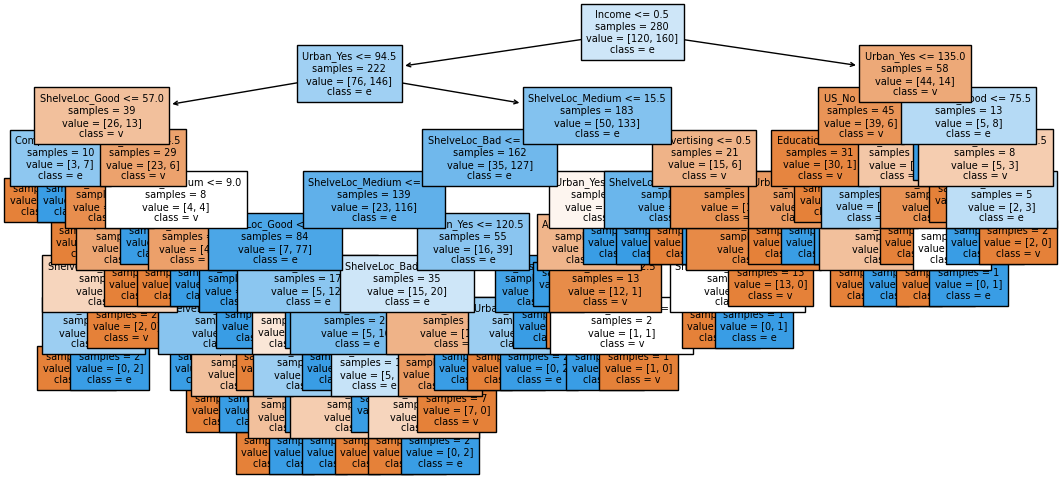

In [ ]:
# Visualizar el modelo (árbol)
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(13, 6))

print(f"Profundidad del árbol: {dtree_model.get_depth()}")
print(f"Número de nodos terminales: {dtree_model.get_n_leaves()}")

plot = plot_tree(
            decision_tree = dtree_model,
            feature_names = labels.tolist(),
            class_names   = 'ventas_altas',
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax
       )

Vamos a entrenar un segundo modelo modificando el parámetro de profundidad del árbol (**max_depth**). En este caso lo limitaremos a 9.

In [ ]:
# Entrenar modelo 2
#----------------------------------------------------------------

# Inicializar el modelo usando los parámetros predeterminados
dtree_model_2 = DecisionTreeClassifier(random_state = 1234, max_depth = 9)

# Ajutar el modelo a los datos

dtree_model_2.fit(X_train_prep, y_train)

DecisionTreeClassifier(max_depth=9, random_state=1234)

In [ ]:
# Predecir para el dataset de Test y Train

y_pred_train = dtree_model_2.predict(X_train_prep)
y_pred_test = dtree_model_2.predict(X_test_prep)

# Información del modelo
# ==============================================================================
print("Precisión del modelo para el train:", accuracy_score(y_train, y_pred_train, normalize=True))
print("Precisión del modelo para el test:", accuracy_score(y_test, y_pred_test, normalize=True))
print(classification_report(y_test, y_pred_test))

Precisión del modelo para el train: 0.9785714285714285
Precisión del modelo para el test: 0.7666666666666667
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        44
           1       0.83      0.79      0.81        76

    accuracy                           0.77       120
   macro avg       0.75      0.76      0.75       120
weighted avg       0.77      0.77      0.77       120



In [ ]:
# Predecir para el dataset de Test y Train

y_pred_train = dtree_model_2.predict(X_train_prep)
y_pred_test = dtree_model_2.predict(X_test_prep)

# Información del modelo
# ==============================================================================
print("Precisión del modelo para el train:", accuracy_score(y_train, y_pred_train, normalize=True))
print("Precisión del modelo para el test:", accuracy_score(y_test, y_pred_test, normalize=True))
print(classification_report(y_test, y_pred_test))

Precisión del modelo para el train: 0.9785714285714285
Precisión del modelo para el test: 0.7666666666666667
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        44
           1       0.83      0.79      0.81        76

    accuracy                           0.77       120
   macro avg       0.75      0.76      0.75       120
weighted avg       0.77      0.77      0.77       120



En este caso, obtenemos un árbol de profundidad 9. Bastante más complejo que el modelo anterior y del cual no obtenemos una mejora sustancial de la métrica de precisión en el conjunto de **test**. Recuerda que el conjunto de test es el que nos permitirá evaluar cómo se comporta el modelo con datos nuevos y que un buen funcionamiento sobre los datos de **train** y el mal rendimiento sobre test puede deberse al sobreajuste del modelo.

Profundidad del árbol: 9
Número de nodos terminales: 50


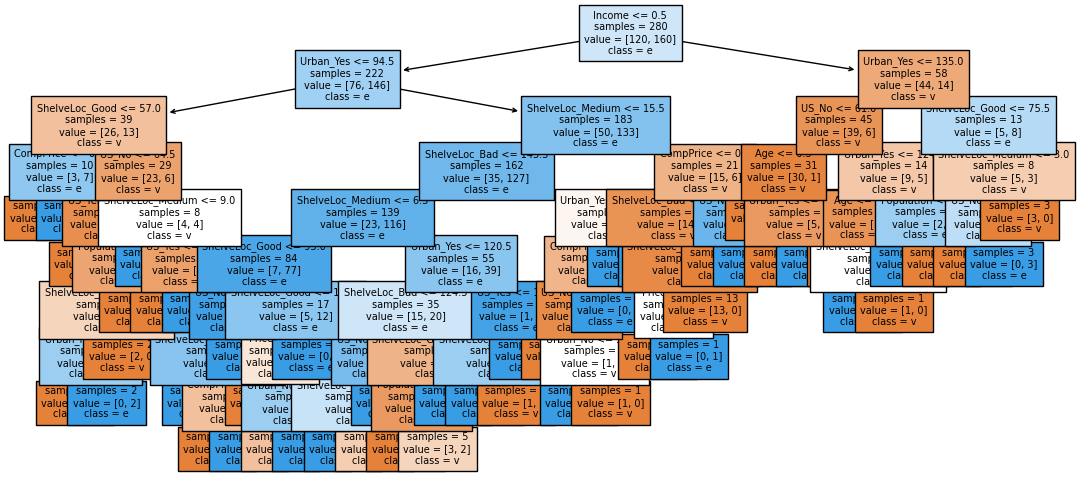

In [ ]:
# Visualizar el modelo (árbol)
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(13, 6))

print(f"Profundidad del árbol: {dtree_model_2.get_depth()}")
print(f"Número de nodos terminales: {dtree_model_2.get_n_leaves()}")

labels = X_train_prep.columns

plot = plot_tree(
            decision_tree = dtree_model_2,
            feature_names = labels.tolist(),
            class_names   = 'ventas_altas',
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax
       )

## Regresión

Para el ejemplo práctico, vamos a continuar con el problema que planteamos en la unidad anterior con la regresión lineal. Vamos a resolver el problema de predicción de los precios de pisos en california desarrollando un algoritmo de árbol de decisión que sea capaz de mejorar el resultado obtenido con la regresión lineal.

Comenzaremos cargando los paquetes correspondientes. En este caso, para modelar un árbol de decisión necesitamos la librería de DecissionTreeRegressor de sklearn. Adicionalmente, usaremos los paquetes plot_tree, export_grpahviz y export_text para visualizar el árbol resultante.

In [ ]:
# Cargar Librerías

# Tratamiento de datos
#--------------------------------------------------------
from sklearn.datasets import fetch_california_housing
import numpy as np

# Visualización
#--------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado: Machine Learning
#--------------------------------------------------------
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.metrics import r2_score

Cargamos los datos y solicitamos la documentación por medio de DESCR. Recordemos que este dataset contenía un total de 8 variables predictivas, todas numéricas. Por lo que no necesitaríamos aplicar ninguna transformación.

In [ ]:
# Generar datos para el problema de regresión lineal
california_housing = fetch_california_housing(as_frame=True)

# Descripción del dataset
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

Realizamos una exploración sencilla de los datos, para verificar la correcta carga y estructura del dataset con la función **head().**

In [ ]:
# Vamos a explorar el dataset
#----------------------------------------------
dataset = california_housing.frame
dataset.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422

In [ ]:
california_housing.frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [ ]:
california_housing.target

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

Creamos las muestras tanto para el train como para el test. Con una muestra del 20% para evaluar el modelo una vez entrenado.

In [ ]:
# Dividimos los datos en train y test
# ------------------------------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
  california_housing.data.drop('AveBedrms', axis = 1),
  california_housing.target,
  train_size   = 0.8,
  random_state = 1234,
  shuffle      = True
)

En esta ocasión, vamos a definir el modelo de los hiperparámetros por defecto, dando libertad de expandir el árbol hasta que el algoritmo reduzca los errores lo máximo posible.

Ajustamos el modelo a los datos de entrenamiento con la ayuda de la función fit()

In [ ]:
# Entrenamos el modelo
#----------------------------------------------------------------
# Inicializamos el modelo usando los parámetros predeterminados
dtree_model = DecisionTreeRegressor(random_state = 1234)

# Ajustamos el modelo a los datos
dtree_model.fit(X_train,  y_train)

DecisionTreeRegressor(random_state=1234)

Usamos el modelo para predecir, tanto para la muestra de test como para el train. En este caso encontramos que el coeficiente de determinación R2 es igual al 100% para el caso del train. Mientras que en el caso del test  es del 69%. Este caso representa un caso típico de sobreajuste de los datos. Por un lado obtenemos métricas “perfectas” para el conjunto de entrenamiento pero al evaluarlo con un conjunto nuevo como es el del test, no obtenemos resultados tan óptimos.  Es por ello que solemos limitar los parámetros del modelo.

In [ ]:
# Predecir para el dataset de Test y Train

y_pred_train1 = dtree_model.predict(X_train)
y_pred_test1 = dtree_model.predict(X_test)

# Información del modelo
# ==============================================================================
print("Profundidad del árbol:", dtree_model.get_depth())
print("Coeficiente de determinación R^2 en train:", r2_score(y_train, y_pred_train1))
print("Coeficiente de determinación R^2 en test:", r2_score(y_test, y_pred_test1))

Profundidad del árbol: 36
Coeficiente de determinación R^2 en train: 1.0
Coeficiente de determinación R^2 en test: 0.6138376706389224


Cabe destacar, que el árbol resultante tiene una profundidad de 36 niveles. Vamos a modificar los parámetros del modelo para tener una nueva aproximación.

In [ ]:
# Entrenamos el modelo
#----------------------------------------------------------------

# Inicializamos el modelo usando los parámetros predeterminados
dtree_model_2 = DecisionTreeRegressor(random_state = 1234, max_depth = 10, min_samples_split = 10)

# Ajustamos el modelo a los datos
dtree_model_2.fit(X_train,  y_train)

DecisionTreeRegressor(max_depth=10, min_samples_split=10, random_state=1234)

Evaluando los resultados, en este caso obtenemos un coeficiente de determinación R2  de 81,3% en el **train** mientras que en el **test** mejoramos la métrica con un 69,81%.

In [ ]:
# Predecir para el dataset de Test y Train

y_pred_train2 = dtree_model_2.predict(X_train)
y_pred_test2 = dtree_model_2.predict(X_test)

# Información del modelo
# ==============================================================================
print("Profundidad del árbol:", dtree_model_2.get_depth())
print("Coeficiente de determinación R^2 en train:", r2_score(y_train, y_pred_train2))
print("Coeficiente de determinación R^2 en test:", r2_score(y_test, y_pred_test2))

Profundidad del árbol: 10
Coeficiente de determinación R^2 en train: 0.8137511310154779
Coeficiente de determinación R^2 en test: 0.6982276591114422


Con el comando siguiente, podrás visualizar el árbol resultante.

In [ ]:
# Visualizar el modelo (árbol)
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(130, 60))

print(f"Profundidad del árbol: {dtree_model_2.get_depth()}")
print(f"Número de nodos terminales: {dtree_model_2.get_n_leaves()}")

labels = X_train.columns

plot = plot_tree(
  decision_tree = dtree_model_2,
  feature_names = labels.tolist(),
  class_names   = 'ventas_altas',
  filled        = True,
  impurity      = False,
  fontsize      = 7,
  ax            = ax
)

Output hidden; open in https://colab.research.google.com to view.

Como puedes observar, incluso restringiendo el árbol a una profundidad máxima de 10 niveles, resulta complicado analizar la visualización final del árbol. Es por ello que se suele balancear el compromiso entre buenas métricas y complejidad del modelo, sobre todo de cara a hacer uso de esta visualización para analizar las variables predictivas.

# Random Forest

La idea detrás de los algoritmos de random forest (o bosques aleatorios), es conformar un conjunto de expertos, en este caso árboles de decisión, capaces de resolver un problema de predicción o de clasificación. A este tipo de estrategia se llama algoritmos de ensemble.

Vamos a comenzar preparando nuestro entorno de trabajo cargando las librerías necesarias para resolver nuestro problema. En esta oportunidad, vamos a desarrollar el problema por medio del algoritmo de random forest, por lo que necesitaremos la función RandomForestClassifier del paquete de sklearn.

In [ ]:
# Cargar Librerías

# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado: Machine Learning
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Descargamos el dataset asociado al problema de **Carseats** de **ISLR** del paquete **statsmodels.api**.

In [ ]:
# Generar datos para el problema de clasificación
carseats = sm.datasets.get_rdataset("Carseats", "ISLR")

# Descripción del dataset
dataset = carseats.data
dataset.head()

Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No

Como ya vimos en el caso práctico de árbol de decisión, necesitamos crear la variable **target** del modelo. Esta variable separará las ventas consideradas altas del resto. Para este problema se consideran **ventas altas** cuando una tienda supera los 8.000 artículos en la variable **Sales** (recuerda que los datos de la columna se consideran en miles).

In [ ]:
# Vamos a crear el variable 'target' con la que haremos la clasificación

dataset['target'] = np.where(dataset.Sales > 8, 0, 1)

# Eliminamos la variable 'Sales' para no duplicar información
dataset.drop(columns = 'Sales', inplace=True)
dataset.head()

CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0        138      73           11         276    120       Bad   42   
1        111      48           16         260     83      Good   65   
2        113      35           10         269     80    Medium   59   
3        117     100            4         466     97    Medium   55   
4        141      64            3         340    128       Bad   38   

   Education Urban   US  target  
0         17   Yes  Yes       0  
1         10   Yes  Yes       0  
2         12   Yes  Yes       0  
3         14   Yes  Yes       1  
4         13   Yes   No       1

Separamos de nuestro dataset las variables predictoras de la variable objetivo

In [ ]:
# Separar variables independientes y dependientes

X = dataset.drop('target', axis=1)
y = dataset.target

Creamos nuestro conjunto de entrenamiento y de test. Al igual que en el caso anterior, y para poder comparar correctamente con los resultados obtenidos con el árbol de decisión, fijamos la semilla aleatoria y la proporción de la muestra a 30%.

In [ ]:
# Dividimos los datos en train y test
# ------------------------------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(X,
	y,
	test_size    = 0.30,
	random_state = 1234,
	shuffle      = True
)

Al igual que la función de **DecisionTreeClassifier**, la función de **RandomForestClassifier** no soporta variables categóricas sin transformar. Recuerda que esta limitación no está asociada al algoritmo, sino más bien a la forma en como **sklearn** procesa los datos.

In [ ]:
# One-hot-encoding de las variables categóricas
# ------------------------------------------------------------------------------

# Identificamos las variables númericas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

# Definimos la trasnformación one-hot-encoding a las variables categóricas
preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough'
               )

Definimos la transformación usando el dataset de **train** para posteriormente aplicarlo tanto al dataset de **train** y **test**.

In [ ]:
# Aplicamos la trasnformación one-hot-encoding a nuestro dataset
# ------------------------------------------------------------------------------

#
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])

# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep  = pd.DataFrame(X_test_prep, columns=labels)

Finalmente, definimos nuestro modelo de **random forest**. En esta oportunidad, fijamos como siempre la semilla de muestreo aleatorio y limitamos la profundidad del árbol a 20 usando el hiperparámetro **max_depth**.

In [ ]:
# Entrenamos el modelo
#----------------------------------------------------------------

# Inicializar el modelo usando los parámetros predeterminados
rforest_model = RandomForestClassifier(random_state = 1234, max_depth = 20)

# Ajutar el modelo a los datos

rforest_model.fit(X_train_prep, y_train)

RandomForestClassifier(max_depth=20, random_state=1234)

Hacemos la predicción para el conjunto de **test** y de **train** y comparamos las métricas.

In [ ]:
# Predecir para el dataset de Test y Train
y_pred_train = rforest_model.predict(X_train_prep)
y_pred_test = rforest_model.predict(X_test_prep)

# Información del modelo
# ==============================================================================
print("Número de árboles (estimadores):", len(rforest_model.estimators_))
print("Precisión del modelo para el train:", accuracy_score(y_train, y_pred_train, normalize=True))
print("Precisión del modelo para el test:", accuracy_score(y_test, y_pred_test, normalize=True))

Número de árboles (estimadores): 100
Precisión del modelo para el train: 1.0
Precisión del modelo para el test: 0.8833333333333333


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.80      0.83        44
           1       0.89      0.93      0.91        76

    accuracy                           0.88       120
   macro avg       0.88      0.86      0.87       120
weighted avg       0.88      0.88      0.88       120



En este caso, con 100 árboles empleados como estimadores obtenemos una precisión del 100% en el conjunto de **train** y del 83% en el conjunto de **test**. Como no queremos que nuestro algoritmo **sobreajuste** los datos de train, vamos a aplicar alguno de los hiperparámetros vistos para limitar el tamaño del árbol.

En esta ocasión, vamos a probar limitando por un lado el número de árboles a entrenar y fijando su profundidad máxima a 5 (**max_depth**).

In [ ]:
# Entrenar modelo 2
#----------------------------------------------------------------

# Inicializar el modelo usando los parámetros predeterminados
rforest_model_2 = RandomForestClassifier(random_state = 1234, max_depth = 5, n_estimators= 7)

# Ajutar el modelo a los datos

rforest_model_2.fit(X_train_prep, y_train)

RandomForestClassifier(max_depth=5, n_estimators=7, random_state=1234)

In [ ]:
# Predecir para el dataset de Test y Train

y_pred_train = rforest_model_2.predict(X_train_prep)
y_pred_test = rforest_model_2.predict(X_test_prep)

# Información del modelo
# ==============================================================================
print("Número de árboles (estimadores):", len(rforest_model_2.estimators_))
print("Precisión del modelo para el train:", accuracy_score(y_train, y_pred_train, normalize=True))
print("Precisión del modelo para el test:", accuracy_score(y_test, y_pred_test, normalize=True))

Número de árboles (estimadores): 7
Precisión del modelo para el train: 0.9214285714285714
Precisión del modelo para el test: 0.8583333333333333


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81        44
           1       0.90      0.87      0.89        76

    accuracy                           0.86       120
   macro avg       0.85      0.85      0.85       120
weighted avg       0.86      0.86      0.86       120



Verificamos los resultados haciendo la predicción tanto en train como en test donde encontramos que con únicamente 7 árboles, somos capaces de encontrar una buena aproximación, una precisión de 92% en el **train** y 85% en el **test**.

Recuerda que para el algoritmo de **random forest**, el aumentar el número de estimadores no mejora siempre la métrica ya que llega a un punto donde se **estabiliza**. Piensa en el siguiente ejemplo, si estamos aplicando una votación entre la clase A y la clase B con un grupo de expertos, si obtenemos A como resultado final, el aumentar indiscriminadamente el número de expertos no hace que la clase A sea más cierta.

Para validar lo anterior, vamos a realizar un pequeño experimento. Vamos a crear una función, que entrene una serie de modelos de **random forest** variando el número de estimadores (entre 1 a 150). Para esta oportunidad, vamos a fijar la profundidad máxima del árbol a 10 y un máximo de variables predictoras (**max_features**=auto, que es equivalente a tomar **√features**).

Valor óptimo de n_estimators: 21
Precisión en test óptima: 0.8583333333333333


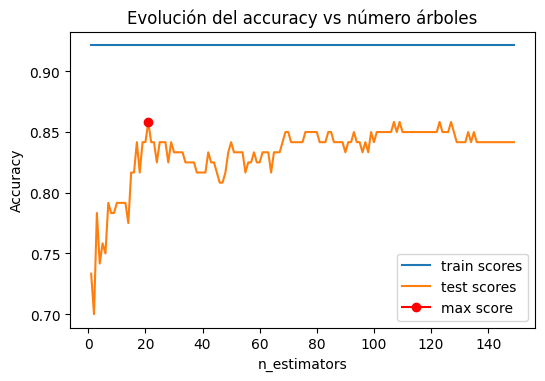

In [ ]:
# Función para estimar el número de estimadores óptimos
# ==============================================================================
train_scores = []
test_scores = []

# Rango de estimadores
estimator_range = range(1, 150, 1)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y test
for n_estimators in estimator_range:
    modelo = RandomForestClassifier(
                n_estimators = n_estimators,
                criterion    = 'gini',
                max_depth    = 10,
                random_state = 1234
             )
    modelo.fit(X_train_prep, y_train)
    train_scores.append(accuracy_score(y_train, y_pred_train, normalize=True))
    y_pred_test = modelo.predict(X_test_prep)
    test_scores.append(accuracy_score(y_test, y_pred_test, normalize=True))

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, test_scores, label="test scores")
ax.plot(estimator_range[np.argmax(test_scores)], max(test_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("Accuracy")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del accuracy vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(test_scores)]}")
print(f"Precisión en test óptima: {max(test_scores)}")

Como podemos observar, notamos que la métrica va mejorando a medida que incluimos más estimadores al modelo. Sin embargo, a partir de cierto número (en torno a 20 árboles) la métrica se estabiliza observando poca diferencia.

Finalmente, con esta configuración hemos encontrado que el mejor modelo de **random forest** es el conformado por 21 árboles obteniendo un 85,83% de precisión.

# Métricas de regresión

Para ilustrar las métricas usadas en problemas de regresión, vamos a considerar el ejemplo de predicción del precio de viviendas que vimos en unidades anteriores con un modelo de regresión lineal.

In [ ]:
# Cargar Librerías

from sklearn.datasets import fetch_california_housing
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

Cargamos el dataset y hacemos la **separación** de train y test. Posteriormente **entrenamos** un modelo de regresión lineal con todas las variables y generamos la **predicción** del conjunto de test.

In [ ]:
# Generar datos para el problema de regresión lineal
california_housing = fetch_california_housing(as_frame=True)

# Separar el dataset de train y test
X_train, X_test, y_train, y_test = train_test_split(
  california_housing.data.drop('AveBedrms', axis = 1),
  california_housing.target,
  train_size   = 0.8,
  random_state = 1234,
  shuffle     = True
)

# Entrenamos un modelo de regresión lineal
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Generamos la predicción
y_pred = modelo.predict(X_test)

Para calcular la **suma de errores cuadráticos**, basta con plantear la fórmula vista en el apartado anterior. Donde se calcula la diferencia entre la predicción y el valor real de cada observación, sumamos todos los resultados y posteriormente se eleva al cuadrado.

In [ ]:
# SSE : Suma de errores cuadráticos

np.sum((y_test - y_pred)**2)

2264.287760406076

En el caso del **MSE** o error cuadrático medio, usaremos la función  **mean_squared_error** de **sklearn.**

In [ ]:
# MSE: Error cuadrático medio

from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred)

0.5485193218037975

De igual manera, para el caso de **R2** vamos a hacer uso de la función **r2_score** de **sklearn**. Donde obtenemos que para este caso el 59% de la variabilidad de los datos se puede explicar con el modelo planteado.

In [ ]:
# R2

from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.5945342038911727

Si queremos obtener un valor que penaliza de alguna forma el uso de más variables, planeamos en este caso el R2 ajustado. En **sklearn** no existe una función que haga el cálculo directamente de esta métrica, por lo que planearemos la fórmula y usaremos el resultado obtenido en el apartado anterior.

Por lo cual, obteniendo el número total de observaciones y número de variables mediante el comando **shape()** obtenemos fácilmente el resultado.

In [ ]:
# R2 ajustado

from sklearn.metrics import r2_score

R2 = r2_score(y_test, y_pred)
n,p = X_train.shape

R2ajusted = 1-(1-R2)*(n-1)/(n-p-1)
R2ajusted

0.5943622297895754

Por lo cual, obteniendo el número total de observaciones y número de variables mediante el comando **shape()** obtenemos fácilmente el resultado.

# Métricas de clasificación

Vamos a plantear un problema sencillo de clasificación para posteriormente calcular las distintas métricas del modelo.

Antes de empezar vamos a cargar las librerías necesarias y crearemos un dataset con datos aleatorios donde tendremos dos clases con un total de 1000 observaciones.

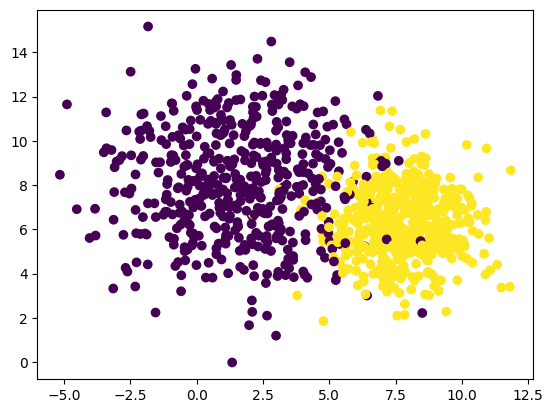

In [ ]:
# Cargar Librerías

import numpy as np
import math
np.random.seed(6)
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Creación del dataset
(X,y) = make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=[2.5,1.5], random_state=20)
X1 = np.c_[np.ones((X.shape[0])),X]

# Visualizar el conjunto
plt.scatter(X1[:,1],X1[:,2],marker='o',c=y)
plt.show()

Definimos un modelo de regresión logística y calculamos las predicciones.

In [ ]:
# Definimos un modelo de clasificación

clf = LogisticRegression(random_state = 123)
clf.fit(X1,y)

predict_y=clf.predict(X1)
predict_y_proba=clf.predict_proba(X1)

Vamos a utilizar tanto las predicciones de las clases como la salida con las probabilidades para el cálculo de las métricas.

Visualizamos el resultado del modelo, donde claramente se puede ver que tenemos observaciones que están mal clasificadas ya que antes hemos visualizado las etiquetas.

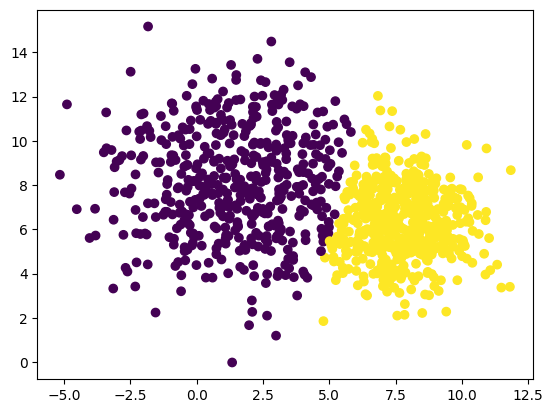

In [ ]:
# Visualizamos el resultado del modelo
plt.scatter(X1[:,1],X1[:,2],marker='o',c=predict_y)
plt.show()

Calculamos la matriz de confusión usando la función **confusion_matrix** de **sklearn**, donde se pueden observar a simple vista que en la diagonal de la matrix se encuentran los valores de **TP** y **TN**.

In [ ]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix

confusion_matrix(y, predict_y)

array([[468,  32],
       [ 16, 484]])

Obtenemos la exactitud del modelo mediante la función **accuracy_score** de **sklearn**.

In [ ]:
# Exactitud o Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y, predict_y)

0.952

Calculamos la precisión del modelo para la clase positiva usando la función **precision_score** de **sklearn**.

In [ ]:
# Precisión

from sklearn.metrics import precision_score

precision_score(y, predict_y)

0.937984496124031

Para calcular la sensitividad, usaremos la función **recall_score** de **sklearn**. Recordamos que esta métrica calcula la tasa de positivos clasificados correctamente, es por ello que el parámetro **pos_label** sea igual a 1 (la clase 1 es la positiva en nuestro ejemplo).

In [ ]:
# Sensibilidad
from sklearn.metrics import recall_score

recall_score(y, predict_y, average='binary', pos_label=1)

0.968

Para calcular la especificidad, hacemos uso de la misma función del caso anterior **recall_score**, pero esta vez modificamos el parámetro **pos_label** a 0, ya que la especificidad calcula la proporción de negativos clasificados correctamente.

In [ ]:
# Especificidad
from sklearn.metrics import recall_score

recall_score(y, predict_y, average='binary', pos_label=0)

0.936

Para el f1-score utilizaremos la función **f1_score** de **sklearn**. Se podría de igual forma utilizar la función general **fbeta_score** fijando en este caso el parámetro **beta** igual a 1.

In [ ]:
# F1-score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

f1_score(y, predict_y, average='binary'), fbeta_score(y, predict_y, average='binary', beta = 1)

(0.952755905511811, 0.952755905511811)

Se puede verificar que en ambos casos se obtiene el mismo resultado.

Para calcular la curva ROC, necesitamos las probabilidades obtenidas del modelo. En este caso, usamos la función **roc_curve** de **sklearn**.

De igual manera, vamos a crear una recta asociada a un modelo aleatorio. Esta linea es equivalente a usar una moneda para resolver un problema de clasificación binaria la cual representará nuestra base a mejorar por cualquier modelo.

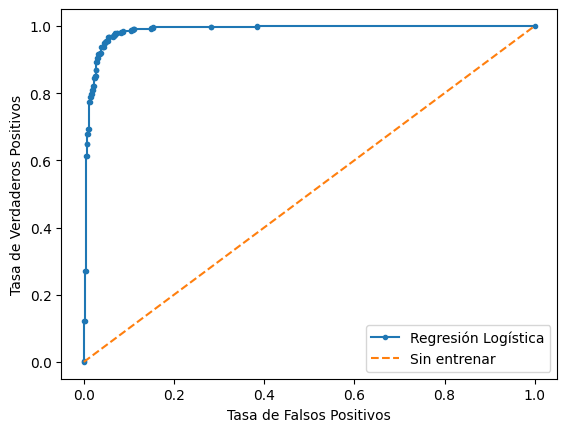

In [ ]:
# Curva ROC
from sklearn.metrics import roc_curve
from matplotlib import pyplot

sin_entrenar_probs = [0 for _ in range(len(y))]

fpr, tpr, _ = roc_curve(y, predict_y_proba[:,1]);
ns_fpr, ns_tpr, _ = roc_curve(y, sin_entrenar_probs);

# Graficar la curva ROC
pyplot.plot(fpr, tpr, marker='.', label='Regresión Logística')
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')

# Etiquetas de los ejes
pyplot.xlabel('Tasa de Falsos Positivos')
pyplot.ylabel('Tasa de Verdaderos Positivos')
pyplot.legend()
pyplot.show()

Finalmente, calculamos el valor del Área bajo la Curva ROC, **AUC**, usando la función **roc_auc_score** de **sklearn**.

In [ ]:
# AUC
from sklearn.metrics import roc_auc_score

roc_auc_score(y, predict_y_proba[:,1])

0.9872160000000001

# Algoritmos de ensemble

Los algoritmos de ensemble (o combinados) consisten en utilizar un conjunto de modelos que llamaremos aprendices débiles o weak learners para obtener un rendimiento predictivo en conjunto que mejore el resultado que se pudiera obtener por medio de un solo modelo.

Como siempre, comenzamos preparando nuestro entorno de trabajo con las librerías necesarias. En este caso, utilizaremos las funciones **VotingClassifier**, **StackingClassifier**, **BaggingClassifier** y **AdaBoostClassifier** de la librería **ensemble** de **sklearn**.

Como **predictores simples** o **aprendices débiles** vamos a usar los modelos de **SVM** (en su versión de clasificación), **árbol de decisión** y **regresión logística**.

In [ ]:
# Cargar Librerías

import numpy as np
import math
np.random.seed(6)
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble._bagging import BaggingClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

Como comentamos anteriormente, vamos a plantear un problema de clasificación binaria. En este caso, usaremos la función **make_moons()**. Tener en cuenta que en esta oportunidad, planteamos un conjunto de entrenamiento más pequeño que el conjunto de test.

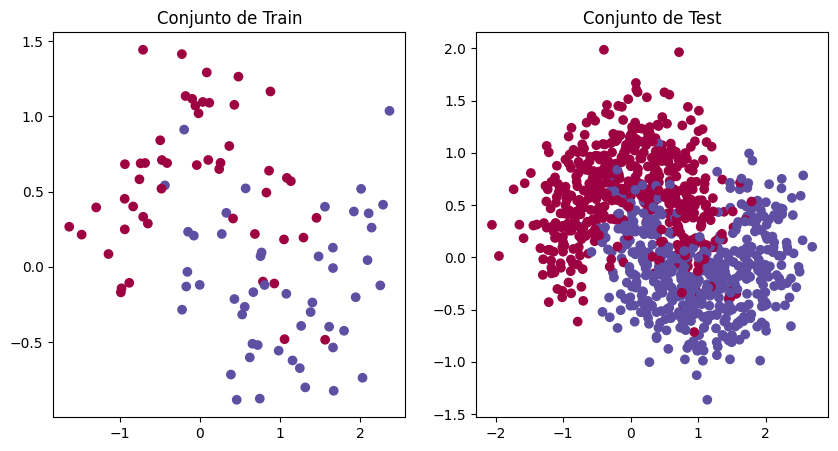

In [ ]:
# Creación del dataset
np.random.seed(16)
x_train, y_train = make_moons(100, noise=0.3)
x_test, y_test = make_moons(1000, noise=0.3)

# Visualizar el conjunto
xx, yy = np.meshgrid(np.arange(-2, 3, 0.05), np.arange(-1.5, 2.0, 0.05))
zz = np.concatenate([xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis]], axis=1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(x_train[:,0], x_train[:,1], c=y_train, cmap=plt.cm.Spectral)
axs[0].set_title('Conjunto de Train')
axs[1].scatter(x_test[:,0], x_test[:,1], c=y_test, cmap=plt.cm.Spectral)
axs[1].set_title('Conjunto de Test')
plt.show()

Vamos a considerar como primera aproximación, tres modelos simples. En este caso SVM, un árbol de decisión y una regresión logística. Estos modelos nos servirán por un lado de base para las estrategias de ensemble que planteamos más adelante y otro lado como base por sí solas en cuanto a la exactitud del modelo.

In [ ]:
# Modelos de clasificación para Voting

svc = SVC(C=10000, gamma='scale', probability=True) # Support vector classifier
dt = DecisionTreeClassifier()                       # Decision tree
lr = LogisticRegression()                           # Logistic regressor

# Entrenamiento
svc.fit(x_train, y_train)
dt.fit(x_train, y_train)
lr.fit(x_train, y_train)

# Evaluación del modelo
y_pred_svc = svc.predict(x_test)
y_pred_dt = dt.predict(x_test)
y_pred_lr = lr.predict(x_test)


print("Accuracy del modelo de SVM:", accuracy_score(y_test, y_pred_svc))
print("Accuracy del modelo de Árbol de Decisión:", accuracy_score(y_test, y_pred_dt))
print("Accuracy del modelo de Regresión Logística:", accuracy_score(y_test, y_pred_lr))

Accuracy del modelo de SVM: 0.842
Accuracy del modelo de Árbol de Decisión: 0.866
Accuracy del modelo de Regresión Logística: 0.835


La primera estrategia que vamos a plantear para resolver el problema es un aprendizaje de tipo **Voting**. Vamos a comparar los resultados tanto para el caso de **hard voting** como para el caso de **soft voting**.

Recuerda que en esta estrategia, la robustez del modelo se obtiene gracias al uso de predictores simples de distintas familias. En este caso vamos a usar los 3 algoritmos que comentamos anteriormente (SVM, árbol de decisión y regresión logística).

Definimos la estructura de voting usando la función **VotingClassifier()**, entrenamos y evaluamos los resultados comparándolos con el conjunto de test.

Para este problema de clasificación, obtenemos un valor de exactitud o accuracy de 88,2% para la estrategía con **hard voting** mientras que con la estrategía de **soft voting** obtenemos un 87,2% de accuracy.

In [ ]:
# Modelos de clasificación para Voting

clf_svc = SVC(C=10000, gamma='scale', probability=True)# Support vector classifier
clf_dt = DecisionTreeClassifier()                      # Decision tree
clf_lr = LogisticRegression()                          # Logistic regressor

# Entrenamiento
clf_hv = VotingClassifier(estimators=[('lr', clf_svc), ('rf', clf_dt), ('gnb', clf_lr)], voting='hard')
clf_sv = VotingClassifier(estimators=[('lr', clf_svc), ('rf', clf_dt), ('gnb', clf_lr)], voting='soft')

clf_hv.fit(x_train, y_train)
clf_sv.fit(x_train, y_train)

# Evaluación del modelo
y_pred_hv = clf_hv.predict(x_test)
y_pred_sv = clf_sv.predict(x_test)

print("Accuracy del modelo con Hard Voting:", accuracy_score(y_test, y_pred_hv))
print("Accuracy del modelo con Soft Voting:", accuracy_score(y_test, y_pred_sv))

Accuracy del modelo con Hard Voting: 0.882
Accuracy del modelo con Soft Voting: 0.875


Replicando el procedimiento para el aprendizaje de tipo **Stacking**, utilizamos nuevamente nuestros predictores simples pero esta vez, incluímos un modelo en la salida de los estimadores simples.

Puedes observar que en la definición del modelo con la función **StackingClassifier()** que el modelo elegido para recolectar la información y entregar la predicción final es un modelo de **regresión logística**, donde adicionalmente aplicamos una técnica de validación de **cross-validation** con 5 partes.

En este caso, la predicción final nos da una exactitud de 88,4%

In [ ]:
# Modelos de clasificación para Stacking

clf_svc = SVC(C=10000, gamma='scale', probability=True)  # Support vector classifier
clf_dt = DecisionTreeClassifier()                        # Decision tree
clf_lr = LogisticRegression()                            # Logistic regressor

# Entrenamiento
clf = StackingClassifier(estimators=[('lr', clf_svc), ('rf', clf_dt), ('gnb', clf_lr)],
  final_estimator=LogisticRegression(),
  cv=5)

clf.fit(x_train, y_train)

# Evaluación del modelo
y_pred = clf.predict(x_test)

print("Accuracy del modelo de Stacking:", accuracy_score(y_test, y_pred))

Accuracy del modelo de Stacking: 0.883


Para la estrategia de tipo Bagging, vamos a desarrollar 3 modelos distintos. Cada uno con una base de predictores simples distintos.

Con esta estrategia, obtenemos las siguientes métricas para cada una de las configuraciones:

- Bagging con SVM: 89,8%
- Bagging con Árboles de Decisión: 90,3%
- Bagging con Regresión Logística: 85,4%

In [ ]:
# Modelos de clasificación para Bagging

clf_svc_bagging = BaggingClassifier(SVC(C=100000, gamma='scale', probability=True), n_estimators=100, max_samples=1.0)
clf_dt_bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, max_samples=1.0)
clf_lr_bagging = BaggingClassifier(LogisticRegression(C=10000, solver='lbfgs'), n_estimators=100, max_samples=1.0)

# Entrenamiento
clf_svc_bagging.fit(x_train, y_train)
clf_dt_bagging.fit(x_train, y_train)
clf_lr_bagging.fit(x_train, y_train)

# Evaluación del modelo
y_pred_svc = clf_svc_bagging.predict(x_test)
y_pred_dt = clf_dt_bagging.predict(x_test)
y_pred_lr = clf_lr_bagging.predict(x_test)

print("Accuracy del modelo SVC con Bagging:", accuracy_score(y_test, y_pred_svc))
print("Accuracy del modelo Decision Tree con Bagging:", accuracy_score(y_test, y_pred_dt))
print("Accuracy del modelo Logistic Regression con Bagging:", accuracy_score(y_test, y_pred_lr))

Accuracy del modelo SVC con Bagging: 0.878
Accuracy del modelo Decision Tree con Bagging: 0.887
Accuracy del modelo Logistic Regression con Bagging: 0.842


Finalmente, vamos a replicar el experimento con un algoritmo de tipo Boosting. En este caso hemos seleccionado Adaboost variando el tipo de predictor simple.

Con esta estrategia, obtenemos las siguientes métricas para cada una de las configuraciones:

- Bagging con SVM: 87,1%
- Bagging con Árboles de Decisión: 87,2%
- Bagging con Regresión Logística: 83,7%

In [ ]:
# Modelos de clasificación para Boosting

clf_svc_boosting = AdaBoostClassifier(SVC(C=100000, gamma='scale', probability=True), n_estimators=100, learning_rate = 0.1)
clf_dt_boosting = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=100, learning_rate = 0.1)
clf_lr_boosting = AdaBoostClassifier(LogisticRegression(C=10000, solver='lbfgs'), n_estimators=100, learning_rate = 0.1)

# Entrenamiento
clf_svc_boosting.fit(x_train, y_train)
clf_dt_boosting.fit(x_train, y_train)
clf_lr_boosting.fit(x_train, y_train)

# Evaluación del modelo
y_pred_svc = clf_svc_boosting.predict(x_test)
y_pred_dt = clf_dt_boosting.predict(x_test)
y_pred_lr = clf_lr_boosting.predict(x_test)

print("Accuracy del modelo SVC con Boosting:", accuracy_score(y_test, y_pred_svc))
print("Accuracy del modelo Decision Tree con Boosting:", accuracy_score(y_test, y_pred_dt))
print("Accuracy del modelo Logistic Regression con Boosting:", accuracy_score(y_test, y_pred_lr))

Accuracy del modelo SVC con Boosting: 0.87
Accuracy del modelo Decision Tree con Boosting: 0.872
Accuracy del modelo Logistic Regression con Boosting: 0.837


En general, como has podido observar se obtienen buenas predicciones con cada uno de las distintas estrategias. En el caso de los métodos de Bagging y Boosting, considera los resultados como base donde posiblemente hay un campo de mejora modificando los hiperparámetros del modelo.

Esta es una ventaja de los modelos más simples, donde con pocos parámetros en algunos casos es posible obtener métricas competitivas.

# Series temporales

Para definir qué es una serie temporal vamos a partir del nombre para explicar las 2 partes que la componen:

- Serie: es una **sucesión** de valores que **representan** una variable o entidad
- Temporal: los valores se capturan en instantes de tiempo **equiespaciados** y **ordenados**

Las series temporales pueden representar una única variable y entonces se le llama univariante o por el contrario pueden representar varias entidades y se les conoce como multivariante o panel.

## Manejo de fechas

In [ ]:
import datetime as dt
import pandas as pd
import numpy as np

In [ ]:

dt.datetime(year=2022, month=9, day=16)

datetime.datetime(2022, 9, 16, 0, 0)

In [ ]:
dt.datetime(year=2022, month=9, day=16, hour=8, minute=59, second=3, microsecond=15)

datetime.datetime(2022, 9, 16, 8, 59, 3, 15)

In [ ]:
dt.datetime(year=2022, month=9, day=16).strftime('%a')

'Fri'

In [ ]:
from dateutil import parser

parser.parse("4th of July, 2022")
parser.parse("Thu Sep 16 18:01")
parser.parse('2022-09-11')

datetime.datetime(2022, 9, 11, 0, 0)

In [ ]:
parser.parse("11/09/2013")

datetime.datetime(2013, 11, 9, 0, 0)

In [ ]:
parser.parse("11/09/2013", dayfirst=True)

datetime.datetime(2013, 9, 11, 0, 0)

In [ ]:
import pandas as pd
pd.to_datetime("4th of July, 2022")

Timestamp('2022-07-04 00:00:00')

In [ ]:
pd.date_range('2022-09-01', '2022-09-16')

DatetimeIndex(['2022-09-01', '2022-09-02', '2022-09-03', '2022-09-04',
               '2022-09-05', '2022-09-06', '2022-09-07', '2022-09-08',
               '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12',
               '2022-09-13', '2022-09-14', '2022-09-15', '2022-09-16'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
pd.date_range('2022-09-01', periods=8)

DatetimeIndex(['2022-09-01', '2022-09-02', '2022-09-03', '2022-09-04',
               '2022-09-05', '2022-09-06', '2022-09-07', '2022-09-08'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
pd.date_range('2022-09-01', periods=8, freq='M')

DatetimeIndex(['2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
               '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30'],
              dtype='datetime64[ns]', freq='M')

In [ ]:
from datetime import timedelta
pd.to_datetime("4th of July, 2022") + timedelta(days=1)

Timestamp('2022-07-05 00:00:00')

In [ ]:
pd.to_datetime("4th of July, 2022") + np.timedelta64(1, 'M')
pd.to_datetime("4th of July, 2022") + np.timedelta64(1, 'Y')

Timestamp('2023-07-04 05:49:12')

Vamos a crear un índice con 5 fechas comprendidas entre el 28 de diciembre de 2021 y el 1 de enero de 2022.

In [ ]:
# paso 1: crear el índice de fecha
date_index = pd.date_range('2021-12-28', periods=5)
date_index

DatetimeIndex(['2021-12-28', '2021-12-29', '2021-12-30', '2021-12-31',
               '2022-01-01'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
# paso 2: asignar el índice a un dataframe
data = pd.Series([0,1,2,3,4], index=date_index)
data

2021-12-28    0
2021-12-29    1
2021-12-30    2
2021-12-31    3
2022-01-01    4
Freq: D, dtype: int64

In [ ]:
data['2021']
#data['2022-01']

2021-12-28    0
2021-12-29    1
2021-12-30    2
2021-12-31    3
Freq: D, dtype: int64

## Preparando series temporales

Cargamos el dataset.

In [ ]:
data_1_df = pd.read_csv('aemet_year_month.csv', sep=';')
data_1_df.head(5)

rain_all  rain_00_06  rain_06_12  rain_12_18  rain_18_24    new_date
0   29634.3      6141.5      6955.3      9319.2      8591.2  2013-05-01
1   21886.2      5392.1      5400.1      5654.4      6314.1  2013-06-01
2   12508.8      1863.3       801.9      3006.0      7135.5  2013-07-01
3   13331.8      2288.7      2483.6      3927.3      5233.9  2013-08-01
4   23053.8      4188.3      4840.3      6940.1      8206.9  2013-09-01

In [ ]:
data_1_df.shape

(64, 6)

In [ ]:
data_1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rain_all    64 non-null     float64
 1   rain_00_06  64 non-null     float64
 2   rain_06_12  64 non-null     float64
 3   rain_12_18  64 non-null     float64
 4   rain_18_24  64 non-null     float64
 5   new_date    64 non-null     object 
dtypes: float64(5), object(1)
memory usage: 3.1+ KB


In [ ]:
data_1_df.dtypes

rain_all      float64
rain_00_06    float64
rain_06_12    float64
rain_12_18    float64
rain_18_24    float64
new_date       object
dtype: object

In [ ]:
data_1_df.index

RangeIndex(start=0, stop=64, step=1)

In [ ]:
dateparse = lambda dates: dt.datetime.strptime(dates, '%Y-%m-%d')

data_2_df = pd.read_csv('aemet_year_month.csv', sep = ';',
                        parse_dates=['new_date'],
                        date_parser=dateparse,
                        index_col='new_date')
data_2_df.head()

rain_all  rain_00_06  rain_06_12  rain_12_18  rain_18_24
new_date                                                            
2013-05-01   29634.3      6141.5      6955.3      9319.2      8591.2
2013-06-01   21886.2      5392.1      5400.1      5654.4      6314.1
2013-07-01   12508.8      1863.3       801.9      3006.0      7135.5
2013-08-01   13331.8      2288.7      2483.6      3927.3      5233.9
2013-09-01   23053.8      4188.3      4840.3      6940.1      8206.9

In [ ]:
data_2_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64 entries, 2013-05-01 to 2018-08-01
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rain_all    64 non-null     float64
 1   rain_00_06  64 non-null     float64
 2   rain_06_12  64 non-null     float64
 3   rain_12_18  64 non-null     float64
 4   rain_18_24  64 non-null     float64
dtypes: float64(5)
memory usage: 3.0 KB


In [ ]:
data_2_df.index

DatetimeIndex(['2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
      

In [ ]:
data_3_df = data_2_df.asfreq('MS')
data_3_df.index

DatetimeIndex(['2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
      

In [ ]:
data_4_df = data_3_df.copy()
data_4_df = data_4_df.asfreq('M')
data_4_df.index

DatetimeIndex(['2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
      

In [ ]:
data_4_df.head(5)

rain_all  rain_00_06  rain_06_12  rain_12_18  rain_18_24
new_date                                                            
2013-05-31       NaN         NaN         NaN         NaN         NaN
2013-06-30       NaN         NaN         NaN         NaN         NaN
2013-07-31       NaN         NaN         NaN         NaN         NaN
2013-08-31       NaN         NaN         NaN         NaN         NaN
2013-09-30       NaN         NaN         NaN         NaN         NaN

## Visualización de series temporales

Vamos a usar los datos de la aerolínea de pasajeros: `airline_passengers.csv`, que contiene el número de pasajeros mensuales de una aerolínea internacional en miles entre los años 1949 y 1960.

In [ ]:
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Podemos observar que nuestro datos tienes 2 variables:

*   La variable value contiene un número entero que refleja el número de pasajeros
*   La variable Month contiene el año y el mes, este formato se corresponde con %Y-%m

In [ ]:
pd.read_csv('airline_passengers.csv', sep=',').head(5)

Month  value
0  1949-01    112
1  1949-02    118
2  1949-03    132
3  1949-04    129
4  1949-05    121

Es importante identificar la columna fecha, parsearla para dejarla en el formato adecuado, y asignarla como index del dataset.

In [ ]:
dateparse = lambda dates: dt.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('airline_passengers.csv', sep=',',
                   parse_dates=['Month'], index_col='Month', date_parser=dateparse)
data.head(5)

value
Month            
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121

### Gráfico de líneas

El gráfico de línea es el más utilizado para obtener una imagen global de la serie temporal que vamos a analizar y analizar su evolución. Más adelante, veremos que podemos utilizarlo para visualizar las distintas partes que tiene una serie temporal. Este gráfico se le conoce en la literatura como run chart o run-sequence chart.

In [ ]:
def plot_df(x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(10,3), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

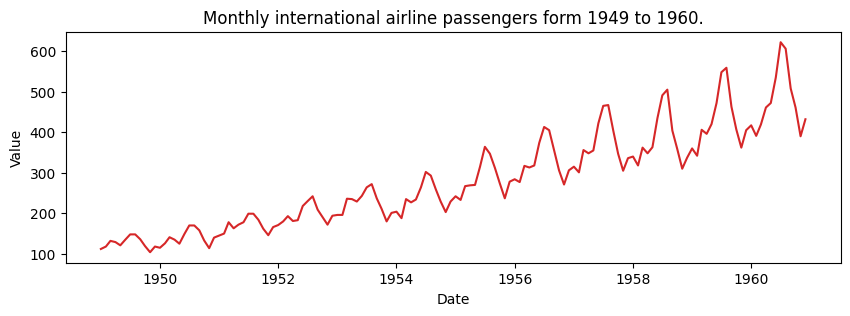

In [ ]:
plot_df(x=data.index, y=data.value, title='Monthly international airline passengers form 1949 to 1960.')

Existe una variante del gráfico de líneas para reflejar la estacionalidad de los datos o intentar reflejar ese patrón mensual.

Para crearlo vamos a generar una copia de los datos ya que vamos a generar unas nuevas variables y de esta forma no modificaremos el data frame original.

In [ ]:
data_for_plots = data.copy()
data_for_plots.reset_index(inplace=True)
data_for_plots.head()

Month  value
0 1949-01-01    112
1 1949-02-01    118
2 1949-03-01    132
3 1949-04-01    129
4 1949-05-01    121

Con la función strftime vamos a extraer los años y los meses de cada fecha, también vamos a sacar el nombre de cada mes. Use un head(1) para observar las variables generadas.

In [ ]:
data_for_plots['year'] = [d.year for d in data_for_plots.Month]
data_for_plots['month'] = [d.strftime('%b') for d in data_for_plots.Month]
data_for_plots['month_n'] = [d.strftime('%m') for d in data_for_plots.Month]
data_for_plots.head()

Month  value  year month month_n
0 1949-01-01    112  1949   Jan      01
1 1949-02-01    118  1949   Feb      02
2 1949-03-01    132  1949   Mar      03
3 1949-04-01    129  1949   Apr      04
4 1949-05-01    121  1949   May      05

In [ ]:
data_for_plots.shape

(144, 5)

También obtenemos en la variable years un listado de los distintos años que vamos a sacar.

Cada uno de estos años va a tener asociado un color, así que vamos a generar un listado de colores aleatorios que guardaremos en mycolors. Ya sabes que cada vez que estamos trabajando con cosas aleatorias es una buena idea definir una semilla que luego nos asegure que los resultados sean reproducibles.

In [ ]:
years = data_for_plots['year'].unique()
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)
mycolors

array(['xkcd:vivid purple', 'xkcd:bright lavender', 'xkcd:sapphire',
       'xkcd:dark fuchsia', 'xkcd:dusky pink', 'xkcd:dusty purple',
       'xkcd:dark tan', 'xkcd:orange brown', 'xkcd:red orange',
       'xkcd:clear blue', 'xkcd:lemon', 'xkcd:bluish grey'], dtype='<U31')

Con el método enumerate vamos a generar un gráfico que añada una línea para cada año filtrando los datos del data frame con la función loc. Esto lo conseguimos con el bucle for. Observa que añadimos una etiqueta en cada línea para facilitar la lectura de los datos.

Los elementos decorativos del gráfico: título, ejes y demás se añaden por fuera del bucle.

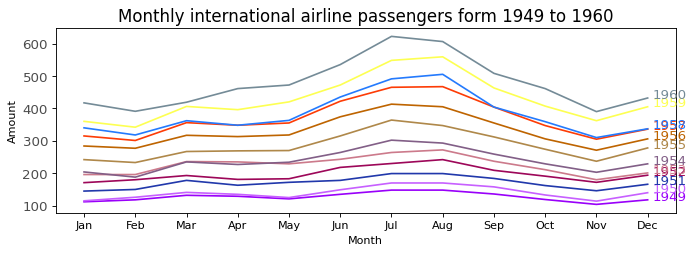

In [ ]:
plt.figure(figsize=(10,3), dpi= 80)
for i_row, i_year in enumerate(years):
    plt.plot('month', 'value',
              data=data_for_plots.loc[data_for_plots.year==i_year, :],
              color=mycolors[i_row],
              label=i_year)
    plt.text(data_for_plots.loc[data_for_plots.year==i_year, :].shape[0]-.9,
             data_for_plots.loc[data_for_plots.year==i_year, 'value'][-1:].values[0],
             i_year,
             fontsize=12, color=mycolors[i_row])

plt.yticks(fontsize=12, alpha=.7)
plt.xlabel('Month')
plt.ylabel('Amount')
plt.title("Monthly international airline passengers form 1949 to 1960", fontsize=15)
plt.show()

### Gráfico de barras

El gráfico de barras nos va a permitir analizar la **evolución** y la **varianza** de los datos en función de la dimensión que usamos en el eje X. Por ello:

- Si usamos el eje X para reflejar los años obtendremos una visión global de la evolución de la serie temporal, lo que vamos a conocer como la tendencia
- Por el contrario si representamos los meses del año en el eje X podremos tener una visión más concreta de cómo cambian los datos a lo largo de un año, esto se conoce como estacionalidad.

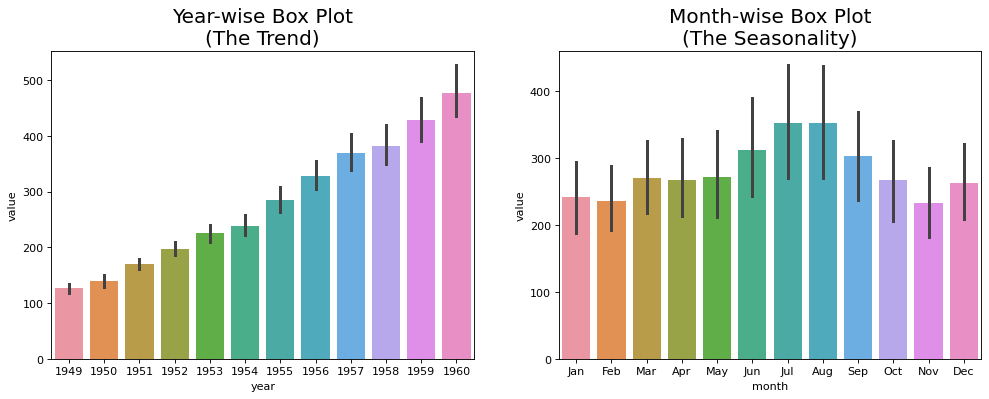

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), dpi= 80)
sns.barplot(x='year', y='value',
            data=data_for_plots, ax=axes[0])
sns.barplot(x='month', y='value',
            data=data_for_plots)

axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18);
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

### Gráfico de cajas

El gráfico de cajas es muy similar al gráfico de barras pero en este caso nos va a permitir obtener más información sobre los valores estadísticos de los datos.

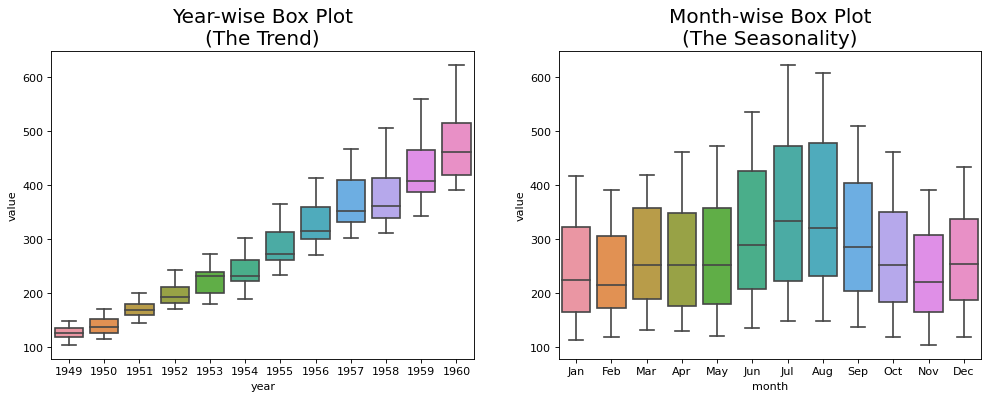

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), dpi= 80)
sns.boxplot(x='year', y='value', data=data_for_plots, ax=axes[0])
sns.boxplot(x='month', y='value', data=data_for_plots)

axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18);
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

### El mapa de calor

Ya te hemos presentado que las series temporales van a tener 2 dimensiones importantes: los años y los meses. Los gráficos que hemos visto hasta ahora solo permiten tener en cuenta una de estas visiones.

En cambio, si usamos un mapa de calor vamos a poder combinar ambas dimensiones de los datos ya que una se refleja en las filas y la otra en las columnas de los datos.

Para el último gráfico, el mapa de calor, necesitamos cambiar la estructura de los datos. Así que vamos a crear un nuevo dataframe: data_for_heatmap con las variables year, month_n que contiene el nombre del mes y el valor de la serie temporal. Muestra 5 filas por pantalla.

In [ ]:
data_for_heatmap = data_for_plots[["year", "month_n", "value"]]
data_for_heatmap.head()

year month_n  value
0  1949      01    112
1  1949      02    118
2  1949      03    132
3  1949      04    129
4  1949      05    121

Ahora mismo nuestros datos tiene un formato “largo” o “long”, es decir, nuestros datos se encuentran ordenados hacía abajo con todos los posibles valores que toman las dos dimensiones: años y meses. Vamos a necesitar transformarlos a un formato “ancho” o “wide” para que las columnas reflejen una de esas dimensiones. Esto se consigue con el comando pivot.

El comando pivot recibe 3 variables:

La variable que va a definir las filas, en nuestro caso será month_n
La variable que va a definir las columnas, en nuestro caso year
El valor que se va a usar para rellenar cada casilla, en nuestro caso value

In [ ]:
data_for_heatmap = data_for_heatmap.pivot("month_n", "year", "value")
data_for_heatmap

<ipython-input-14-abdbf10b19bd>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data_for_heatmap = data_for_heatmap.pivot("month_n", "year", "value")


year     1949  1950  1951  1952  1953  1954  1955  1956  1957  1958  1959  \
month_n                                                                     
01        112   115   145   171   196   204   242   284   315   340   360   
02        118   126   150   180   196   188   233   277   301   318   342   
03        132   141   178   193   236   235   267   317   356   362   406   
04        129   135   163   181   235   227   269   313   348   348   396   
05        121   125   172   183   229   234   270   318   355   363   420   
06        135   149   178   218   243   264   315   374   422   435   472   
07        148   170   199   230   264   302   364   413   465   491   548   
08        148   170   199   242   272   293   347   405   467   505   559   
09        136   158   184   209   237   259   312   355   404   404   463   
10        119   133   162   191   211   229   274   306   347   359   407   
11        104   114   146   172   180   203   237   271   305   310   362   
12        118   140   166   194   201   229   278   306   336   337   405   

year     1960  
month_n        
01        417  
02        391  
03        419  
04        461  
05        472  
06        535  
07        622  
08        606  
09        508  
10        461  
11        390  
12        432

Para generar el gráfico usaremos el comando heatmap de seaborn:

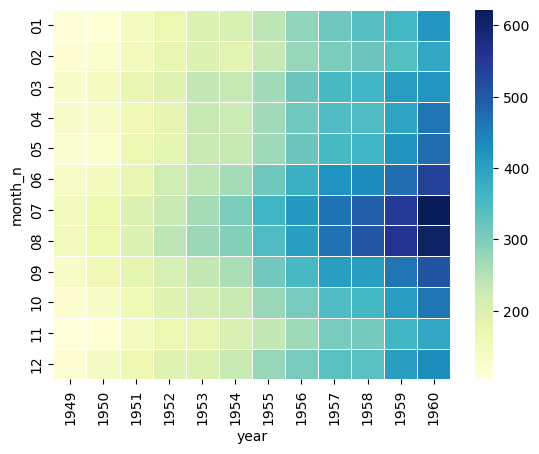

In [ ]:
ax = sns.heatmap(data_for_heatmap, linewidths=.5, cmap="YlGnBu")

## Componentes de series temporales

Una serie temporal la podemos descomponer en 3 elementos:

- **Tendencia:** Es una componente que refleja una evolución a largo plazo y que crece o decrece.
- **Estacionalidad o componente cíclica:** Son dos componente periódicas que se van a repetir a lo largo de nuestra serie temporal pero con distinto periodo: mientras las estacionalidad se centra en el corto plazo la componente cíclica es a largo plazo. Dentro de poco vamos a profundizar un poco más en estas dos componentes.
- **Ruido, residuo o error:** Es la última componente de la serie temporal y es aleatoria e irregular. Por tanto, es incontrolable e impredecible.

**Componente estacional:**
- Es un movimiento periódico a **corto plazo**.
- Consiste en un patrón periódico que se repite debido al **calendario** (los trimestres o los meses). Algunos ejemplos son el aumento del consumo de agua en el verano o el impacto de las fiestas de Navidad en las empresas de retail.
- Lleva asociado un periodo **fijo** y **conocido**.

**Componente cíclica:**
- Es un movimiento periódico a **largo plazo**.
- Su patrón periódico se debe a las **fluctuaciones económicas** o a los ciclos de negocios, por tanto, está relacionada con la macroeconomía.
- Tiene un periodo de al menos **2 años** pero no es fijo.

### Modos de composición

Los componentes de las series temporales se combinan a partir de la operación suma o de la operación multiplicación, dando lugar a lo que llamaremos modo aditivo o modo multiplicativo.

Si una serie temporal tiene valores iguales a cero o próximos a cero el modelo multiplicativo puede generar problemas ya que a la hora de despejar las componentes y utilizar por tanto la operación de la división podemos tener **indeterminaciones** al dividir por cero.

Decir que una serie temporal sigue un modelo aditivo o multiplicativo no es más que darle una **etiqueta** que nos permite entender mejor nuestra serie temporal pero esta clasificación de nuestros datos no tiene **ningún impacto** en el resto de pasos para modelar.

**¿Cómo podemos decir que nuestra serie temporal sigue un modelo aditivo o multiplicativo?**

**Análisis visual de nuestros datos**

- Una serie con un **modelo aditivo** tendrá una varianza **constante** a lo largo del tiempo, es decir, su componente estacional tiene el mismo impacto en todos los intervalos de tiempo.
- Una serie con un **modelo multiplicativo** va a tener una forma **exponencial** ya que la varianza se irá haciendo más grande conforme el paso del tiempo.

**Prueba de la regla:**

Es Aditiva si al pasar los dedos como una regla sobre la gráfica no se abren los dedos.

Es Multiplicativa si es necesario abrir y cerrar los dedos.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
x_range = np.arange(1, 121)
seasonal_ad = [11, 13, 12, 15, 19, 23, 21, 28, 20, 17, 15, 12]
time_series_ad = []

for chunk in np.split(x_range, 10):
    for i, value in enumerate(chunk):
        time_series_ad.append(value + seasonal_ad[i])

df_ad = pd.DataFrame(data = {'y': time_series_ad},
                     index = pd.date_range(start='2010-01-01', periods =120, freq='MS'))
df_ad.head()

y
2010-01-01  12
2010-02-01  15
2010-03-01  15
2010-04-01  19
2010-05-01  24

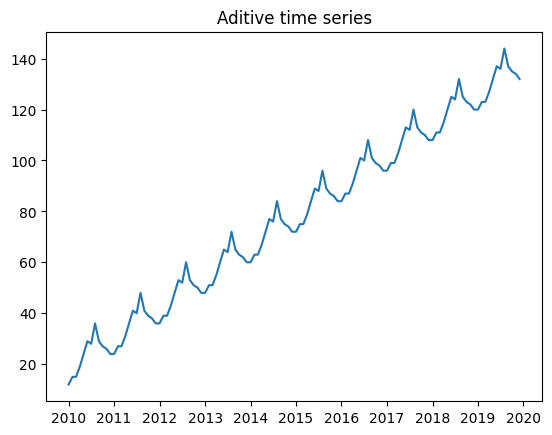

In [ ]:
plt.title('Aditive time series')
plt.plot(df_ad);

In [ ]:
seasonal_mult = [11, 13, 12, 15, 19, 23, 21, 28, 20, 17, 15, 12]
time_series_mult = []

for chunk in np.split(x_range, 10):
    for i, value in enumerate(chunk):
        time_series_mult.append(value * seasonal_mult[i])

df_mult = pd.DataFrame(data = {'y': time_series_mult},
                     index = pd.date_range(start='2010-01-01', periods =120, freq='MS'))
df_mult.head()

y
2010-01-01  11
2010-02-01  26
2010-03-01  36
2010-04-01  60
2010-05-01  95

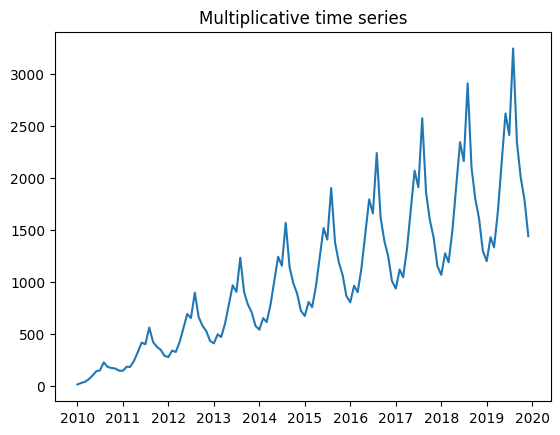

In [ ]:
plt.title('Multiplicative time series')
plt.plot(df_mult);

Para llevar a cabo la descomposición usaremos el comando **seasonal_decompose** (recuerda que vamos a verlo en detalle en el siguiente apartado) y podemos generar ese gráfico de componentes que veíamos antes con el comando **plot**. Lo importante en este apartado es definir el parámetro **model** como **additive**.

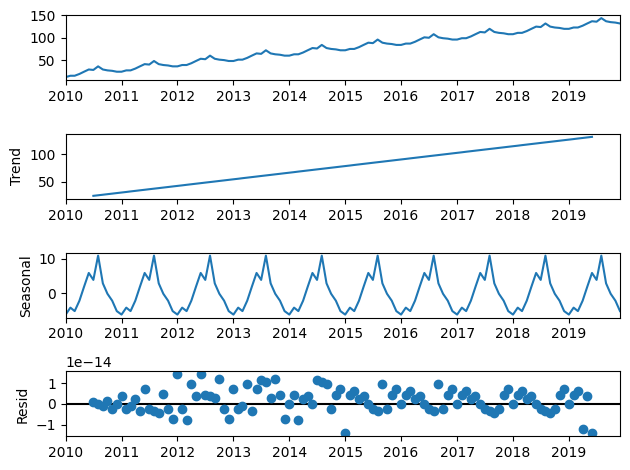

In [ ]:
seasonal_decompose(df_ad, model='additive').plot();

En nuestro caso, nos queremos centrar en el residuo así que accederemos a dicha componente con **.resid** y generamos el gráfico correspondiente. Observa que el gráfico se encuentra centrado en cero y la varianza es muy pequeña.

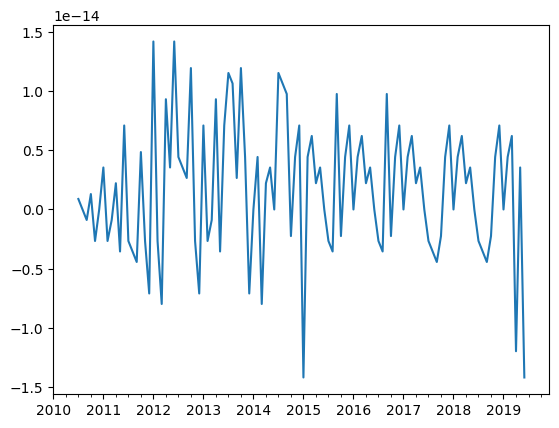

In [ ]:
seasonal_decompose(df_ad, model='additive').resid.plot();

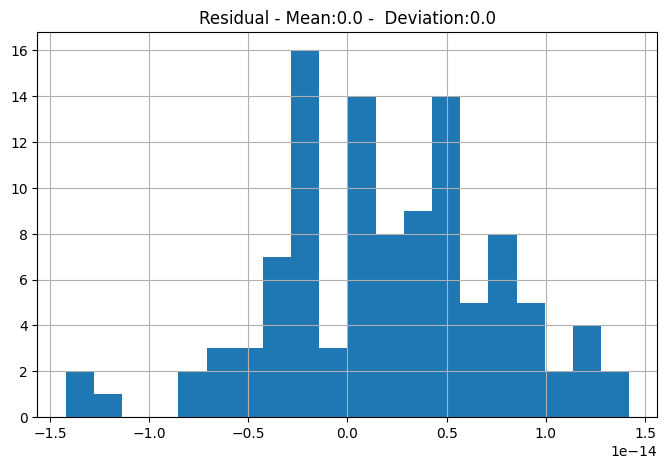

In [ ]:
rcParams['figure.figsize'] = 8, 5
seasonal_decompose(df_ad, model='additive').resid.hist(bins=20)
plt.title(f"Residual - Mean:{round(seasonal_decompose(df_ad, model='additive').resid.mean(), 5)} - \
 Deviation:{round(seasonal_decompose(df_ad, model='additive').resid.std(), 5)}");

### Descomponiendo una serie temporal

In [ ]:
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
dateparse = lambda dates: dt.datetime.strptime(dates, '%Y-%m')
data_df = pd.read_csv('airline_passengers.csv',
  sep = ',',
  parse_dates=['Month'], date_parser=dateparse,
  index_col='Month')

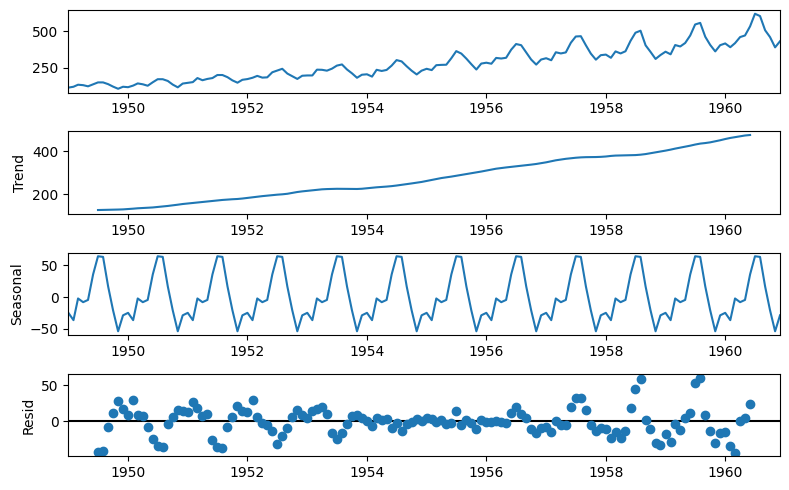

In [ ]:
decompose_ad = seasonal_decompose(data_df, model='additive')
decompose_ad.plot();

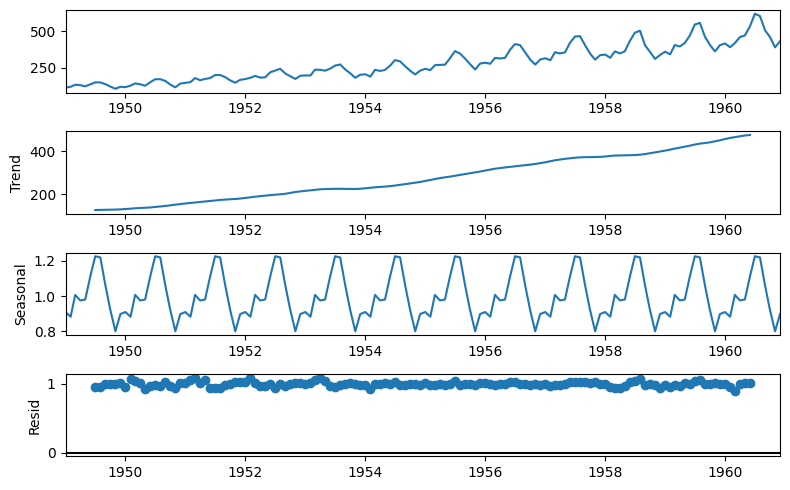

In [ ]:
decompose_mult = seasonal_decompose(data_df, model='multiplicative')
decompose_mult.plot();

In [ ]:
reconstructed_df = pd.concat([
  decompose_ad.trend,
  decompose_ad.seasonal,
  decompose_ad.resid,
  decompose_ad.observed
], axis=1)

In [ ]:
reconstructed_df.columns = ['trend', 'seasonal', 'residual', 'actual_values']
reconstructed_df.head()

trend   seasonal  residual  actual_values
Month                                                
1949-01-01    NaN -24.748737       NaN          112.0
1949-02-01    NaN -36.188131       NaN          118.0
1949-03-01    NaN  -2.241162       NaN          132.0
1949-04-01    NaN  -8.036616       NaN          129.0
1949-05-01    NaN  -4.506313       NaN          121.0

## Comprobando la estacionariedad

Una serie temporal es **no estacionaria**:

- Si tiene una componente de **tendencia** que varía con el tiempo.
- Si la **varianza** no se mantiene constante, es decir, si sigue un modelo **multiplicativo.**
- Si tiene una componente **estacional** (independientemente de su periodo).

Hay 4 métodos de comprobación de estacionareidad.


### Análisis visual
Empezamos con el **análisis visual** de la serie temporal, y para ello podemos enfocarlo de dos formas:

1. Realizando un **gráfico** que muestre la evolución de la serie temporal para ver si somos capaces de identificar la existencia de una componente de tendencia o de estacionalidad
2. Hacer una **descomposición ETL** y representar los resultados para analizar la existencia de ambas componentes.

In [ ]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [ ]:
dateparse = lambda dates: dt.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('airline_passengers.csv', sep=',',
  parse_dates=['Month'], date_parser=dateparse,
  index_col='Month')

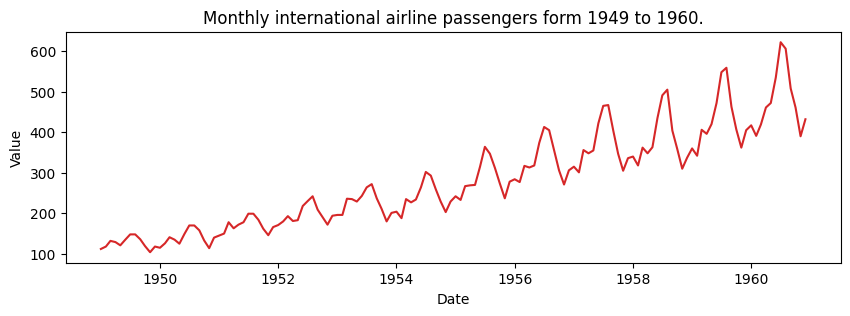

In [ ]:
plot_df(x=data.index, y=data.value,
  title='Monthly international airline passengers form 1949 to 1960.')

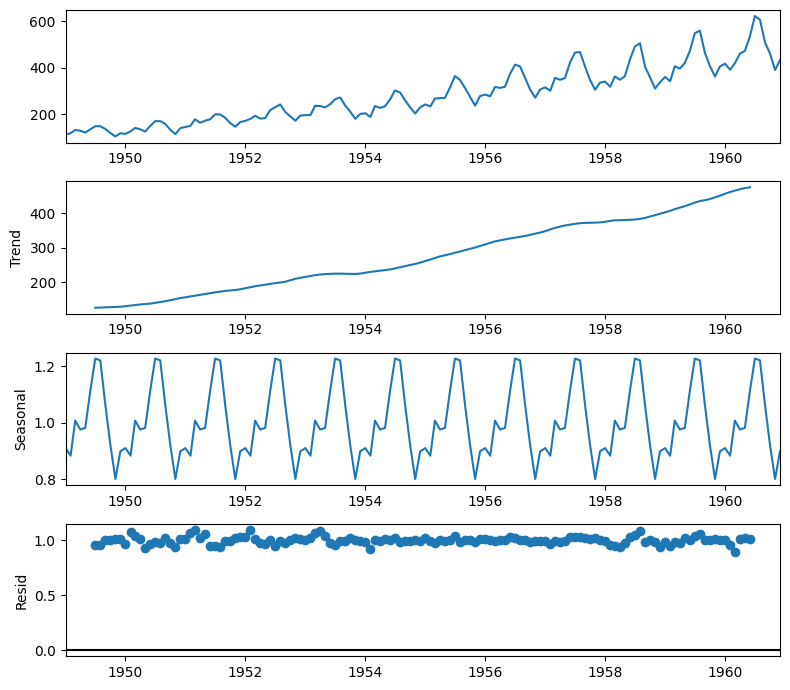

In [ ]:
rcParams['figure.figsize'] = 8, 7
decomposed_df = seasonal_decompose(data, model='multiplicative')
decomposed_df.plot();

### Parámetros estadísticos móviles

La segunda técnica consiste en obtener los **parámetros estadísticos** (media y varianza) en distintos instantes temporales para comprobar si se mantienen constantes o no. Igual que antes podemos hacerlo de dos formas distintas:

1. Obtener la **media móvil** y la **varianza móvil** y comprobar si son constantes o no
2. Separar la serie temporal en **2 partes** para obtener los estadísticos sobre ellas para comparar si son iguales o no.

Para obtener la media móvil y la varianza móvil vamos a crear unas ventanas deslizantes con la función **rolling** de pandas (puedes leer más detalles sobre esta función [aquí](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html)). Por ello definimos el tamaño de la ventana como una constante, **N**, igual a 12. Elegimos este valor ya que los datos tienen una frecuencia mensual.

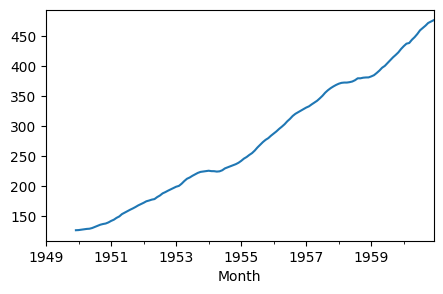

In [ ]:
N=12
rcParams['figure.figsize'] = 5,3
data['value'].rolling(window=N).mean().plot();

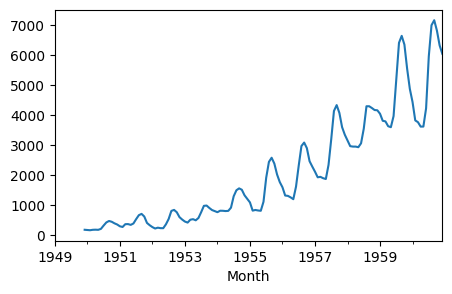

In [ ]:
rcParams['figure.figsize'] = 5,3
data['value'].rolling(window=N).var().plot();

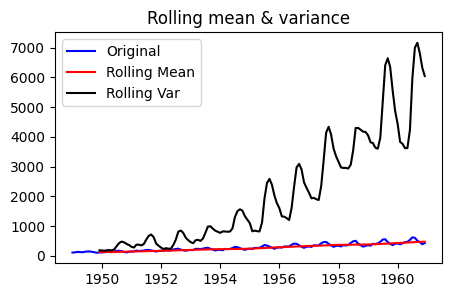

In [ ]:
def test_stationarity(timeseries, N):
  #Determing rolling statistics
  rol_mean = timeseries.rolling(window=N).mean()
  rol_var = timeseries.rolling(window=N).var()

  #Plot rolling statistics
  orig = plt.plot(timeseries, color='blue', label='Original')
  mean = plt.plot(rol_mean, color='red', label='Rolling Mean')
  var = plt.plot(rol_var, color='black', label='Rolling Var')
  plt.legend(loc='best')
  plt.title('Rolling mean & variance')
  plt.show()

test_stationarity(data['value'], N)

Observa la tendencia creciente de la tendencia y el patrón de la varianza cuyos valores se van haciendo más grandes a lo largo de la serie temporal. Podemos concluir, por tanto, que la serie temporal es no estacionaria.

Ahora vamos a ver la forma de separar nuestra serie temporal es 2 partes sobre las que obtener los valores estadísticos.

Lo primero será obtener el tamaño de cada parte y para ello usamos la **longitud** de la serie temporal dividida entre 2. Redondeamos el número con la función round ya que necesitamos un entero para indexar la serie temporal.

In [ ]:
split = round(len(data['value'].values)/2)
split

72

Con este valor vamos a poder dividir la serie temporal en dos partes: new_ts1 y new_ts2. Vamos a seleccionar los valores correspondientes sobre los **values** de la serie temporal:

- Para la primera parte usaremos los valores comprendidos entre 0 y el valor medio que hemos obtenido antes, split
- Para la segunda parte, usaremos los valores desde split hasta el final.

In [ ]:
new_ts1, new_ts2 = data['value'].values[0:split], data['value'].values[split:]

print('mean_1 = %f, mean_2 = %f' %(new_ts1.mean(), new_ts2.mean()))
print('var_1 = %f, var_2 = %f' %(new_ts1.var(), new_ts2.var()))

mean_1 = 182.902778, mean_2 = 377.694444
var_1 = 2244.087770, var_2 = 7367.962191


Observa que los valores son muy diferentes, por lo que la serie temporal es no estacionaria.

### Autocorrelación

La tercera técnica consiste en usar la **autocorrelación** de una serie temporal.

La **correlación** refleja la fuerza de la **relación** entre 2 variables con un valor numérico entre -1 y 1 que representan la correlación negativa o positiva respectivamente.

Si el coeficiente de correlación es igual a 0 significa que no existe correlación entre ambas variables, es decir, las variables no están relacionadas.

Si la correlación mide la relación entre dos variables, para trabajar con series temporales usaremos la autocorrelación que mide la relación entre la serie temporal y una versión de sí misma retrasada múltiples veces. A esta versión retrasada de la serie temporal se la conoce como **lag**.

La fuerza entre las distintas versiones de la serie temporal se representa en un gráfico llamado correlograma o gráfico de autocorrelación. En este gráfico, el eje X refleja el desplazamiento de la serie

Observa que el coeficiente de autocorrelación es muy próximo a 1, por tanto la serie está correlacionada consigo misma y será no estacionaria.

In [ ]:
data['value'].autocorr()

0.9601946480498523

Para obtener el correlograma usamos la función **plot_acf**. En el caso del autocorrelograma podemos ver que no sigue ese patrón que decrece rápidamente y que la mayoría de los valores se encuentran por encima del umbral de confianza, podemos concluir que la serie es no estacionaria.

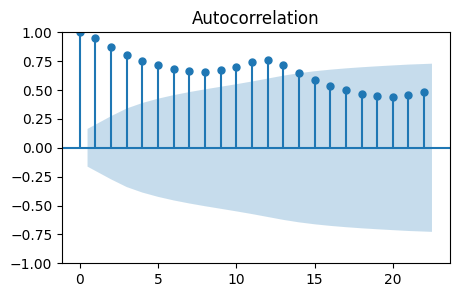

In [ ]:
plot_acf(data['value']);

### Test de hipótesis

En el caso de las series temporales usaremos el **test de raíz unitaria**.

El test de raíz unitaria dice que si nuestra serie temporal tiene una raíz unitaria quiere decir que sus propiedades estadísticas no son constantes con el tiempo.

En nuestro caso, vamos a usar el test de hipótesis de Dickey-Fuller que data de 1979 y que fue enunciado por David A. Dickey y Wayne A. Fuller. Su hipótesis nula enuncia que “existe una raíz unitaria y por ello los parámetros estadísticos no son constantes”.

Para aplicar el test estadístico sobre nuestros datos vamos a usar la función **adfuller**, que como se puede ver a continuación nos proporciona varios valores:

- El valor que devuelve el test estadístico, en nuestro caso 0,81
- El p-valor correspondiente, en nuestro caso 0,99.
- El número de lags que se usan en el cálculo
- El número de observaciones utilizadas, que son 130 en nuestro caso
- Los valores críticos, que son los valores del test estadístico para determinados umbrales de confianza: 1%, 5% y 10%
- El valor máximo del criterio de información según Akaike, AIC

El p-value es una zona verde al lade la curva que indica que la hipótesis nula es verdadera.

In [ ]:
result_adf = adfuller(data['value'])
result_adf

(0.8153688792060498,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

¿Cómo leemos estos resultados? Si el valor del test es **menor o igual** que los valores críticos **podemos rechazar** la hipótesis nula, es decir, **no existe** una raíz unitaria y por tanto los parámetros estadísticos son **constantes** y **la serie temporal es estacionaria**.

Si por el contrario, el valor del test es mayor que los valores críticos **no** podemos rechazar la hipótesis nula, y por tanto, **existe** una raíz unitaria que implica que los parámetros estadísticos **no son constantes** y **la serie temporal no es estacionaria**.

Para facilitar el análisis de aquí en adelante, podemos utilizar esta lógica para **definir una función** que se encarga de hacer la comparación y de proporcionar el resultado correspondiente.

En nuestra función vamos a obtener el test estadístico sobre la serie temporal y vamos a comparar el resultado con un determinado umbral:

In [ ]:
def interpret_dftest(ts, th):
  # Dickey-Fuller test
  result_adf = adfuller(ts)

  print('ADF Statistic: %f' % result_adf[0])
  print('p-value: %f' % result_adf[1])
  print('Critical Values:')
  for key, value in result_adf[4].items():
    print('\t%s: %.3f' % (key, value))

    if result_adf[1] <= th and result_adf[0] <= list(result_adf[4].items())[1][1]:
      print("We can reject the null hypothesis. Time series is stationary.")
    else: print("Time series is not stationary.")

interpret_dftest(data['value'], 0.05)

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
Time series is not stationary.
	5%: -2.884
Time series is not stationary.
	10%: -2.579
Time series is not stationary.


### Conversión de series temporales a procesos estacionarios

Hemos hablado de la importancia de tener series temporales estacionarias y con las nociones que hemos visto, parece seguro aventurar que en una gran mayoría de veces las series temporales que nos vamos a encontrar no serán estacionarias. Entonces, ¿qué podemos hacer?

Existen numerosas técnicas para transformar las series temporales:

- La diferenciación de la serie (una vez o más)
- Transformaciones matemáticas como el logaritmo o la raíz cuadrada
- Eliminar la componente de la tendencia extraída previamente de alguna de la formas que hemos expuesto anteriormente

In [ ]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

def plot_df(x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
  plt.figure(figsize=(10,3), dpi=dpi)
  plt.plot(x, y, color='tab:red')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

def test_stationarity(timeseries, N):
  #Determing rolling statistics
  rolmean = timeseries.rolling(window=N).mean()
  rolstd = timeseries.rolling(window=N).var()

  #Plot rolling statistics:
  orig = plt.plot(timeseries, color='blue',label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

def interpret_dftest(ts, th):
  # Dickey-Fuller test
  result_adf = adfuller(ts)

  # Print values
  print('ADF Statistic: %f' % result_adf[0])
  print('p-value: %f' % result_adf[1])
  print('Critical Values:')
  for key, value in result_adf[4].items():
    print('\t%s: %.3f' % (key, value))

  # Result
  if result_adf[1] <= th and result_adf[0] <= list(result_adf[4].items())[1][1]:
    print('We can reject the null hypothesis. Time series is stationary')
  else: print('Time series is not stationary')

In [ ]:
dateparse = lambda dates: dt.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('airline_passengers.csv', sep=',',
  parse_dates=['Month'], index_col='Month', date_parser=dateparse)

Comprobamos que la serie temporal no es estacionaria:

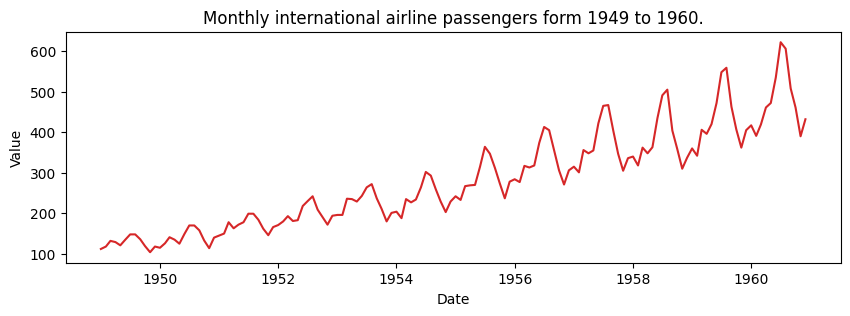

In [ ]:
plot_df(x=data.index, y=data.value,
  title='Monthly international airline passengers form 1949 to 1960.')

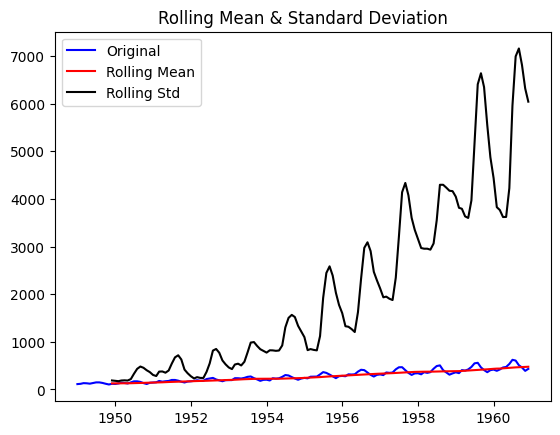

In [ ]:
test_stationarity(data['value'], 12)

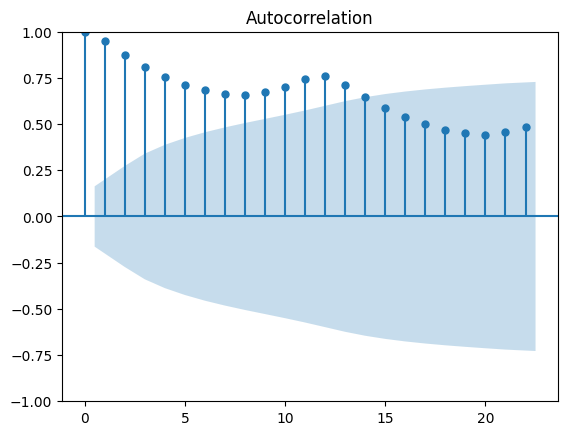

In [ ]:
plot_acf(data['value']);

In [ ]:
interpret_dftest(data['value'], 0.05)

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Time series is not stationary


En todas ellas observamos que los datos no son estacionarios ya que existe una componente de tendencia y de estacionalidad muy claras, además los valores del correlograma se encuentran por encima del umbral de confianza y el test de Dickey-Fuller nos da un valor de 0.81 que es bastante superior los valores comprendidos entre -2.57 y -3.48 de los valores críticos.

#### 1. Diferenciación

La primera estrategia es la **diferenciación** y consiste en restar a los datos una versión **retrasada** de los mismos. Para ello vamos a utilizar el comando **shift**.

Generamos unos datos de prueba con 5 enteros y les asignamos 5 fechas comprendidas entre el 1 de enero de 2020 y el 5 de enero de 2020.

In [ ]:
df = pd.DataFrame({'Col1': [10, 20, 15, 30, 45]},
  index=pd.date_range('2020-01-01', '2020-01-05'))
df

Col1
2020-01-01    10
2020-01-02    20
2020-01-03    15
2020-01-04    30
2020-01-05    45

Generamos una columna nueva para guardar los datos retrasados y mostramos el resultado por pantalla. Observa que se ha generado un valor **NaN**.

In [ ]:
df['Col1_shift'] = df['Col1'].shift(1)
df

Col1  Col1_shift
2020-01-01    10         NaN
2020-01-02    20        10.0
2020-01-03    15        20.0
2020-01-04    30        15.0
2020-01-05    45        30.0

El siguiente paso sería **restar** a los datos originales la versión desplazada de los mismos. Esto lo vamos a ver sobre nuestros datos reales creando una nueva variable.

In [ ]:
data['monthly_diff'] = data['value'] - data['value'].shift(1)
data.head()

value  monthly_diff
Month                          
1949-01-01    112           NaN
1949-02-01    118           6.0
1949-03-01    132          14.0
1949-04-01    129          -3.0
1949-05-01    121          -8.0

Aplicamos las 4 técnicas para comprobar la estacionariedad del resultado:

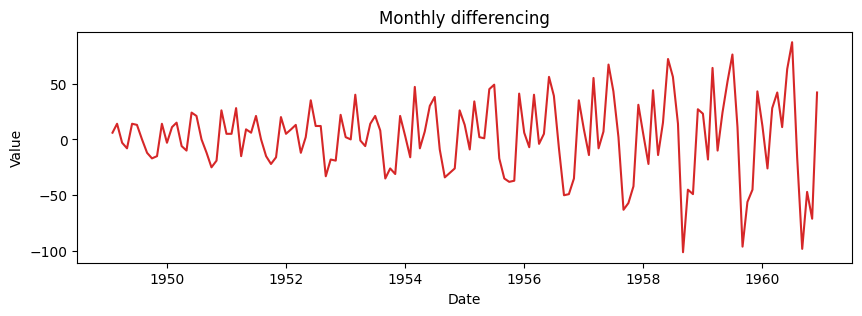

In [ ]:
plot_df(x=data.index, y=data.monthly_diff,
  title='Monthly differencing')

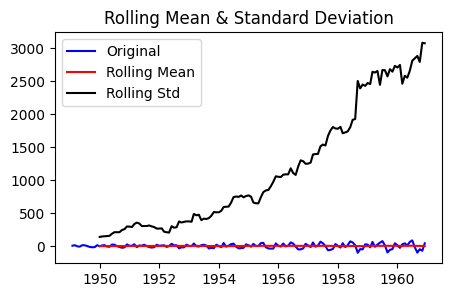

In [ ]:
test_stationarity(data['monthly_diff'], 12)

Presta **atención** a la hora de ejecutar el correlograma. El resultado es inesperado, una línea plana. Esto se debe a la presencia de NaNs y para evitarlo tenemos que usar el comando **dropna**.

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


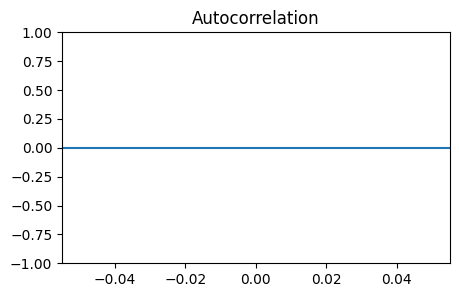

In [ ]:
plot_acf(data['monthly_diff']);

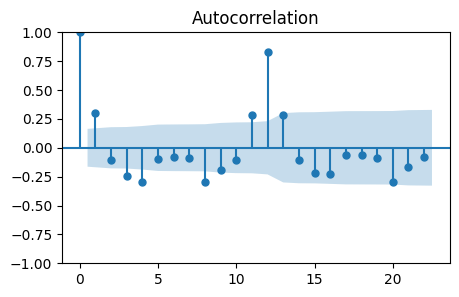

In [ ]:
plot_acf(data['monthly_diff'].dropna());

Si intentamos ejecutar el test estadístico nos sale por pantalla un mensaje de **error** que hace referencia a esos NaNs y vamos a solucionarlo de la misma manera, con el comando **dropna**.

In [ ]:
interpret_dftest(data['monthly_diff'].dropna(), 0.05)

ADF Statistic: -2.829267
p-value: 0.054213
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Time series is not stationary


#### 2. Diferenciación estacional

Existe una versión modificada de la diferenciación que tiene especial interés cuando se trabajan con series temporales con una **fuerte componente estacional**: de nada sirve restar a los datos de diciembre el valor de noviembre, tiene más sentido a cada mes restarle el valor del mismo mes pero en el año anterior. Esto se conoce como **diferenciación estacional** o seasonal differencing.

Vamos a implementarlo modificando el valor que le pasamos al comando **shift**, en este caso usaremos el número 12 ya que de esta forma restaremos el efecto del mismo mes: enero con enero, febrero con febrero… y así sucesivamente.

In [ ]:
data['seasonal_diff'] = data['value'] - data['value'].shift(12)

Si aplicamos las 4 técnicas de comprobación de estacionariedad podemos observar en el gráfico de línea que sobre los datos se elimina la componente de tendencia y la componente estacional es apenas perceptible. En cambio, podemos entrever una **componente cíclica**.

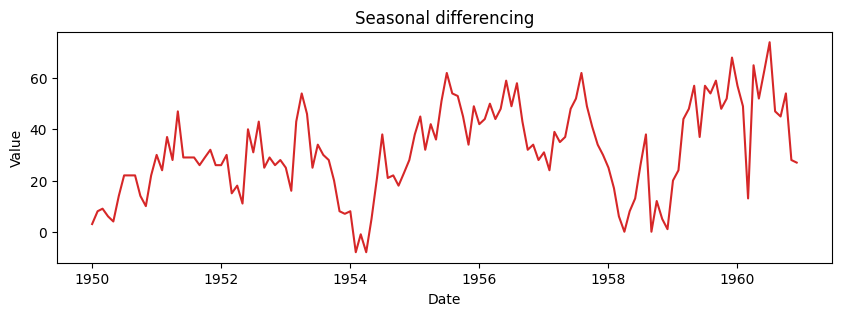

In [ ]:
plot_df(x=data.index, y=data.seasonal_diff,
  title='Seasonal differencing')

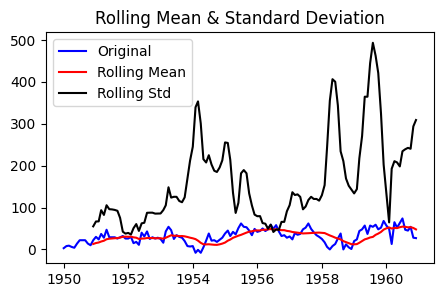

In [ ]:
test_stationarity(data['seasonal_diff'], 12)

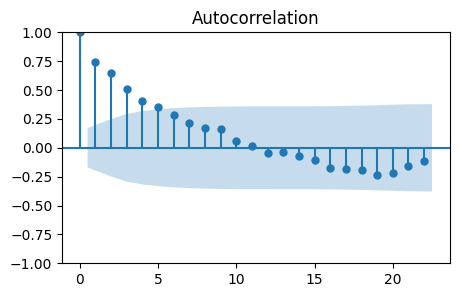

In [ ]:
plot_acf(data['seasonal_diff'].dropna());

In [ ]:
interpret_dftest(data['seasonal_diff'].dropna(), 0.05)

ADF Statistic: -3.383021
p-value: 0.011551
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
We can reject the null hypothesis. Time series is stationary


#### 3. Log transformation

Una nueva estrategia es el uso del **logaritmo** con la función **log** de la librería **numpy**.

In [ ]:
data['log_value'] = np.log(data['value'])

Observa el impacto de la operación en el análisis de los resultados, suaviza un poco nuestros datos ya que los valores son un poco más pequeños pero tienen el mismo patrón de estacionalidad:

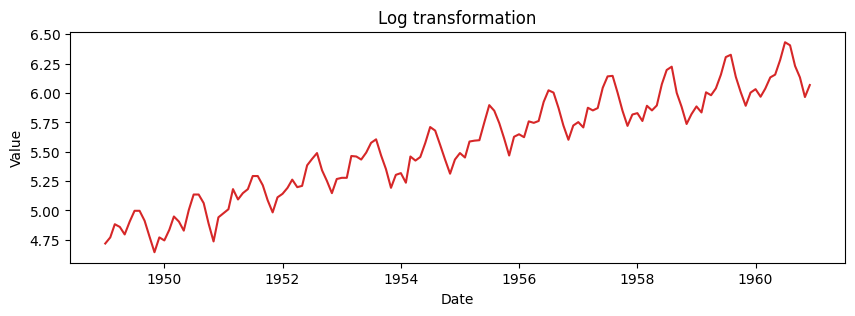

In [ ]:
plot_df(x=data.index, y=data.log_value,
  title='Log transformation')

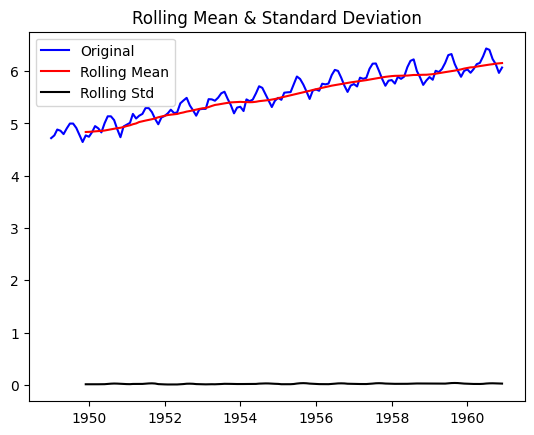

In [ ]:
test_stationarity(data['log_value'], N)

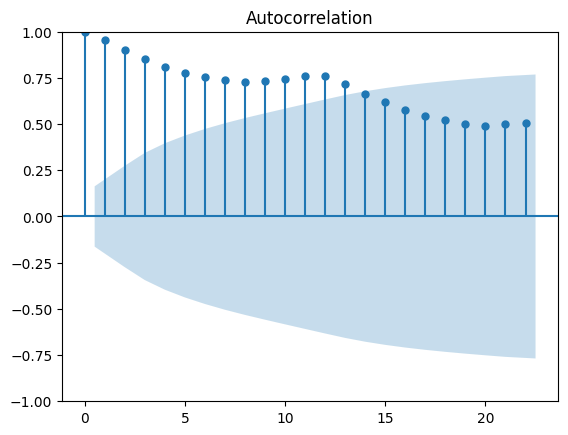

In [ ]:
plot_acf(data['log_value'].dropna());

In [ ]:
interpret_dftest(data['log_value'].dropna(), 0.05)

ADF Statistic: -1.717017
p-value: 0.422367
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Time series is not stationary


#### 4. Square root transformation

Otra estrategia que tiene un impacto similar es el uso de la **raíz cuadrada** con la función **sqrt**.

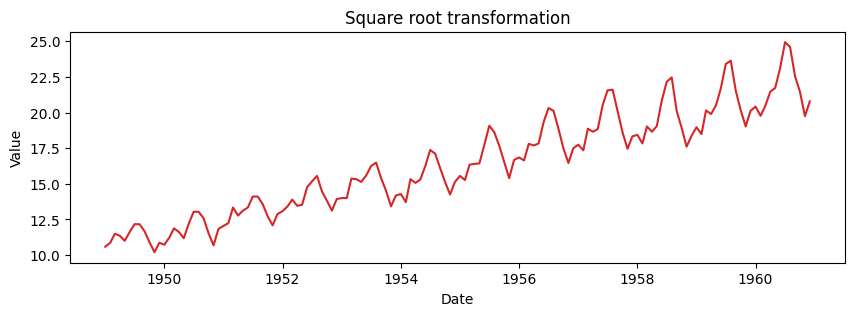

In [ ]:
data['sqrt_value'] = np.sqrt(data['value'])

plot_df(x=data.index, y=data.sqrt_value,
  title='Square root transformation')

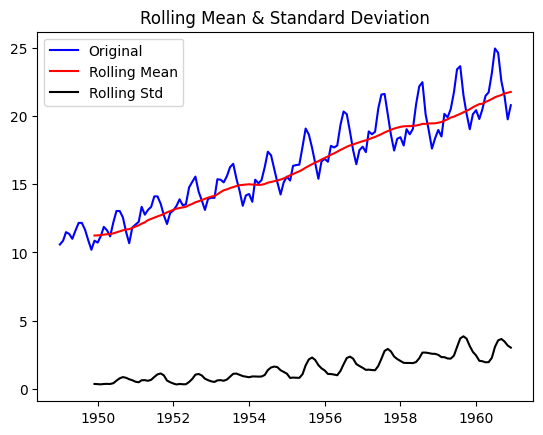

In [ ]:
N=12
test_stationarity(data['sqrt_value'], N)

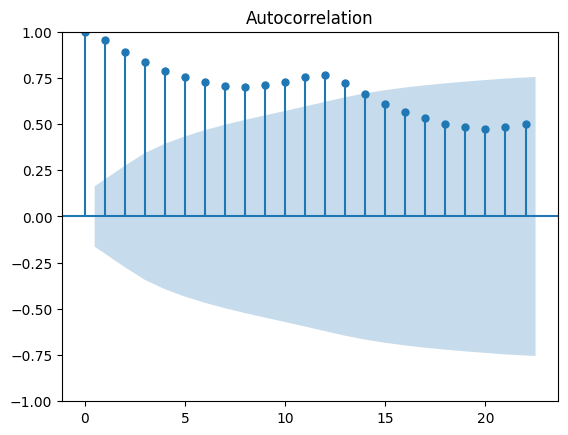

In [ ]:
plot_acf(data['sqrt_value'].dropna());

In [ ]:
interpret_dftest(data['sqrt_value'].dropna(), 0.05)

ADF Statistic: -0.345854
p-value: 0.918754
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Time series is not stationary


#### 5. Remove the trend

Otra técnica que se utiliza mucho es eliminar la componente de la tendencia. En este caso usaremos la función **rolling** para hacer la media de los últimos 12 meses y restaremos dicho valor a la variable **value**.

In [ ]:
data['value_without_trend'] = data['value'] - data['value'].rolling(window = N).mean()

Aplica las mismas piezas de código que hemos visto en las secciones anteriores para analizar el impacto de esta técnica. Ahora, en el gráfico de la variable podemos observar que la amplitud de la serie se va haciendo cada vez más grande. La media permanece centrada en cero mientras la ventana móvil de la varianza muestra valores crecientes. La forma del correlograma es diferente a lo que veníamos observando: aparecen valores positivos y negativos que se van alternando a la vez que su altura decrece. Por último, el test estadístico nos indica que la serie es estacionaria, pero una vez más, el análisis global no indica lo mismo.

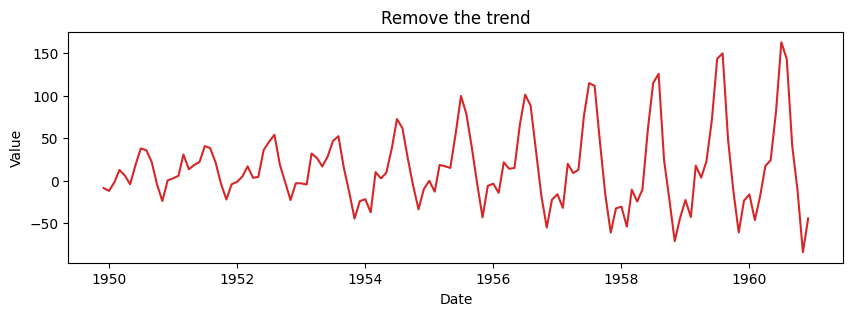

In [ ]:
plot_df(x=data.index, y=data.value_without_trend,
  title='Remove the trend')

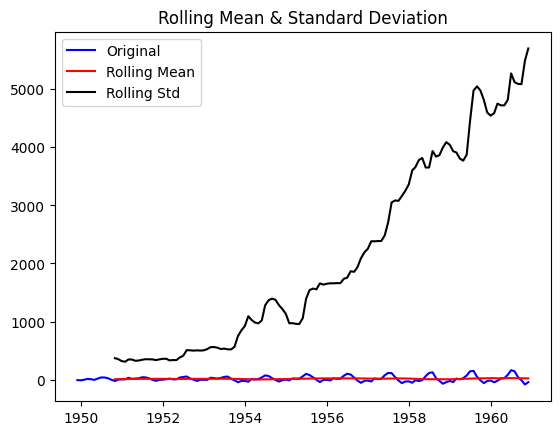

In [ ]:
test_stationarity(data['value_without_trend'], 12)

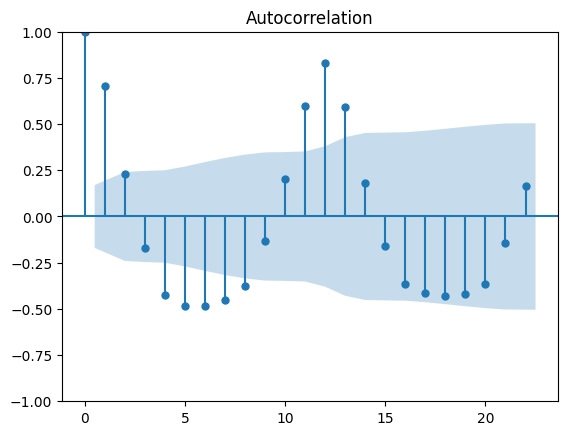

In [ ]:
plot_acf(data['value_without_trend'].dropna());

In [ ]:
interpret_dftest(data['value_without_trend'].dropna(), 0.05)

ADF Statistic: -3.164968
p-value: 0.022104
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
We can reject the null hypothesis. Time series is stationary


Por último, vamos a ver la forma de combinar varias de estas técnicas. En nuestro ejemplo vamos a combinar el logaritmo y la diferenciación:

In [ ]:
data['log_diff_value'] = data['log_value'] - data['log_value'].shift(1)

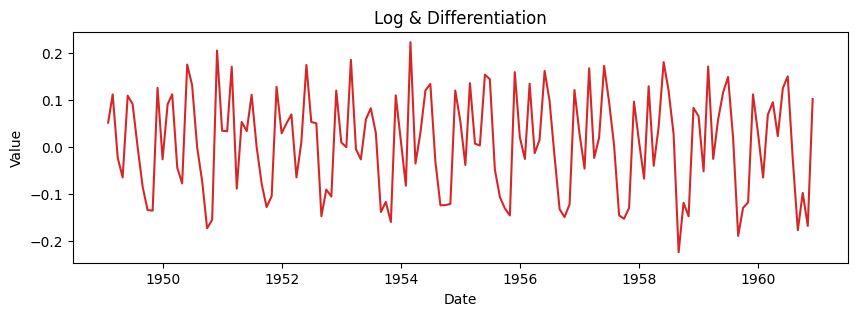

In [ ]:
plot_df(x=data.index, y=data.log_diff_value,
  title='Log & Differentiation')

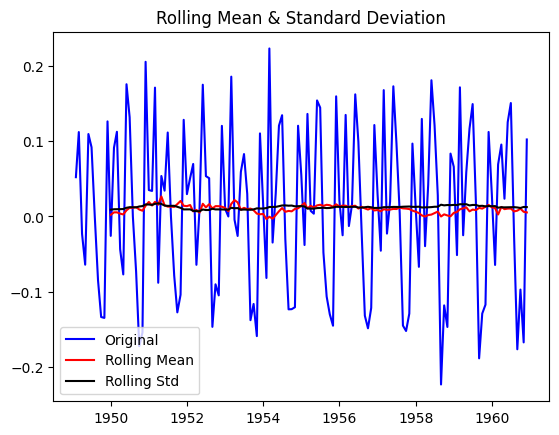

In [ ]:
test_stationarity(data['log_diff_value'], 12)

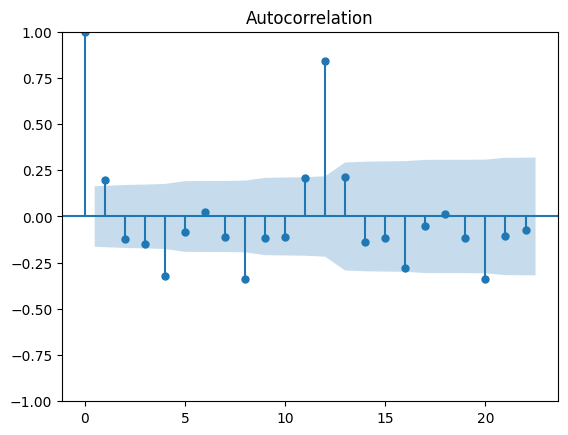

In [ ]:
plot_acf(data['log_diff_value'].dropna());

In [ ]:
interpret_dftest(data['log_diff_value'].dropna(), 0.05)

ADF Statistic: -2.717131
p-value: 0.071121
Critical Values:
	1%: -3.483
	5%: -2.884
	10%: -2.579
Time series is not stationary


**No existe una receta perfecta en esto**, sino la experiencia y la experimentación para aprender lo que mejor funciona en unos casos u otros.

## Predicción

Existen una miríada de modelos para series temporales, pero en nuestro caso vamos a clasificarlos en 3 grupos:

- Modelos de benchmarking para aquellos modelos más sencillos conceptualmente y rápidos
- Modelos basados en los valores pasados y los errores de predicción pasados. Normalmente se les denomina ARIMA (Autoregressive Integrated Moving Average)
- Modelos basados en otras librerías o herramientas

### Modelos de benchmarking

Estos modelos de benchmarking son modelos muy sencillos y muy rápidos que nos muestran cuál sería la mínima predicción que podríamos hacer ya que se basan en reglas lógicas. Además, son modelos en los que no necesitamos hacer la serie estacionaria.

Podemos definir 4 tipos de modelos de benchmarking:

1. Media de la serie temporal
2. Media de los últimos N periodos
3. Último valor o naive
4. El último patrón periódico o seasonal naive

In [ ]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
dateparse = lambda dates: dt.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('airline_passengers.csv', sep=',',
  parse_dates=['Month'], index_col='Month', date_parser=dateparse)

Vamos a separar los datos en train y test ya que vamos a simular la predicción de los datos de los últimos 12 meses, es decir, los valores para el año 1960.

In [ ]:
data_train = data[:'1959-12-01']
data_test = data['1960-01-01':]
data_train.shape, data_test.shape

((132, 1), (12, 1))

Puede ser útil comprobar que no hay solapes entre ambos conjuntos viendo el último valor del conjunto de train y el primer valor del conjunto de test.

In [ ]:
print(data_train.tail(1))

print(data_test.head(1))

            value
Month            
1959-12-01    405
            value
Month            
1960-01-01    417


Empezamos con el primer modelo de benchmarking: el valor medio de la serie temporal, para ello obtenemos la media del conjunto de train y lo guardamos en el conjunto de test.

In [ ]:
data_test['y_hat_mean'] = data_train['value'].mean()
data_test.head()

<ipython-input-8-c47f98422327>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['y_hat_mean'] = data_train['value'].mean()


value  y_hat_mean
Month                        
1960-01-01    417  262.492424
1960-02-01    391  262.492424
1960-03-01    419  262.492424
1960-04-01    461  262.492424
1960-05-01    472  262.492424

La media de los últimos N periodos tiene más sentido ya que nos abstraemos de los valores iniciales de la serie temporal si esta es muy larga y los valores difieren mucho a los actuales. En este caso, usamos N = 12 ya que es el último periodo.

In [ ]:
data_test['y_hat_mean_last_n'] = data_train['value'].rolling(12).mean().iloc[-1]
data_test.head()

<ipython-input-9-93b63a3f9587>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['y_hat_mean_last_n'] = data_train['value'].rolling(12).mean().iloc[-1]


value  y_hat_mean  y_hat_mean_last_n
Month                                           
1960-01-01    417  262.492424         428.333333
1960-02-01    391  262.492424         428.333333
1960-03-01    419  262.492424         428.333333
1960-04-01    461  262.492424         428.333333
1960-05-01    472  262.492424         428.333333

Otra técnica muy sencilla, la naive, consiste en decir que los valores predichos serán igual al último valor de la serie temporal.

In [ ]:
data_test['y_hat_naive'] = data_train['value'].iloc[-1]
data_test.head()

<ipython-input-10-b48e6b928a6a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['y_hat_naive'] = data_train['value'].iloc[-1]


value  y_hat_mean  y_hat_mean_last_n  y_hat_naive
Month                                                        
1960-01-01    417  262.492424         428.333333          405
1960-02-01    391  262.492424         428.333333          405
1960-03-01    419  262.492424         428.333333          405
1960-04-01    461  262.492424         428.333333          405
1960-05-01    472  262.492424         428.333333          405

Por último , en series temporales con una componente estacional muy fuerte puede tener sentido estimar los valores futuros como el último ciclo y para eso seleccionamos los últimos 12 valores de la serie temporal.

In [ ]:
data_test['y_hat_naive_seasonal'] = data_train['value'].iloc[-12:].values
data_test.head()

<ipython-input-11-22d70709f3ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['y_hat_naive_seasonal'] = data_train['value'].iloc[-12:].values


value  y_hat_mean  y_hat_mean_last_n  y_hat_naive  \
Month                                                           
1960-01-01    417  262.492424         428.333333          405   
1960-02-01    391  262.492424         428.333333          405   
1960-03-01    419  262.492424         428.333333          405   
1960-04-01    461  262.492424         428.333333          405   
1960-05-01    472  262.492424         428.333333          405   

            y_hat_naive_seasonal  
Month                             
1960-01-01                   360  
1960-02-01                   342  
1960-03-01                   406  
1960-04-01                   396  
1960-05-01                   420

In [ ]:
data_test.tail()

value  y_hat_mean  y_hat_mean_last_n  y_hat_naive  \
Month                                                           
1960-08-01    606  262.492424         428.333333          405   
1960-09-01    508  262.492424         428.333333          405   
1960-10-01    461  262.492424         428.333333          405   
1960-11-01    390  262.492424         428.333333          405   
1960-12-01    432  262.492424         428.333333          405   

            y_hat_naive_seasonal  
Month                             
1960-08-01                   559  
1960-09-01                   463  
1960-10-01                   407  
1960-11-01                   362  
1960-12-01                   405

Si bien es cierto que podemos aventurar que la calidad de las predicciones no va a ser gran cosa, puede ser de utilidad generar un gráfico que visualiza las mismas:

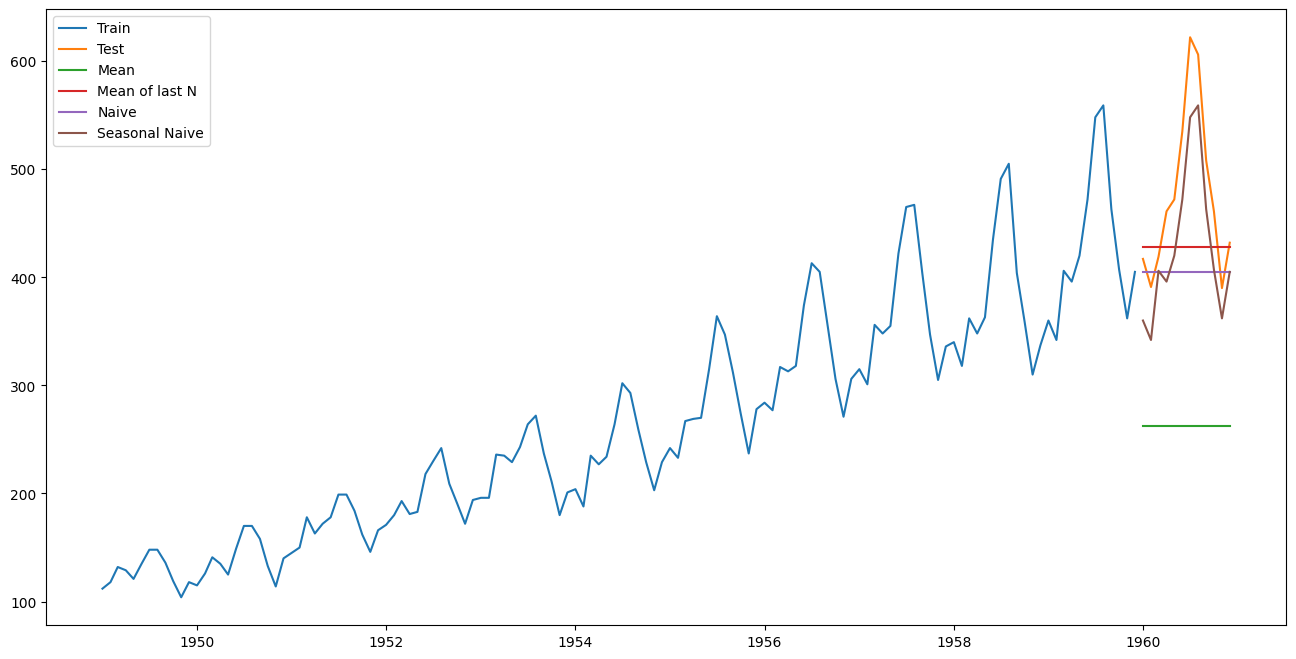

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data_train['value'], label='Train')
plt.plot(data_test['value'], label='Test')
plt.plot(data_test['y_hat_mean'], label='Mean')
plt.plot(data_test['y_hat_mean_last_n'], label='Mean of last N')
plt.plot(data_test['y_hat_naive'], label='Naive')
plt.plot(data_test['y_hat_naive_seasonal'], label='Seasonal Naive')
plt.legend(loc='best')
plt.show()

### Modelos AR

Hemos presentado los modelos ARIMA cuyas siglas vienen de Autoregressive Integrated Moving Average y estos modelos se pueden dividir en 3 partes:

- La parte autorregresiva, AR
- La parte de integración, I
- La parte de media móvil, MA

Empezamos presentando los modelos autorregresivos de orden 1 o comúnmente llamados AR(1).

Estos modelos se basan en predecir el valor de la serie en el instante t usando el **valor de la serie** en el instante t-1. La primera referencias de estos modelos las podemos encontrar en los trabajos de Eugene Slutsky de 1927 “The summation of random causes as the source of cyclic processes”.

El orden hace referencia al número de instantes pasados que se van a tener en consideración para construir el modelo.

¿Cómo elegimos el orden de nuestro modelo AR? A través de los gráficos de autocorrelación y de autocorrelación parcial:

- Los modelos autorregresivos o AR llevan asociados un gráfico de autocorrelación con un **patrón que se desvanece**.
- El orden viene determinado por la última delta significativa (es decir, cuyo valor está por encima de los límites de confianza) del gráfico de autocorrelación parcial. A partir de ese valor p, las deltas serán casi nulas.

In [ ]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller, pacf

In [ ]:
def interpret_dftest(ts, th):
  # Dickey-Fuller test
  result_adf = adfuller(ts)

  # Print values
  print('ADF Statistic: %f' % result_adf[0])
  print('p-value: %f' % result_adf[1])
  print('Critical Values:')
  for key, value in result_adf[4].items():
    print('\t%s: %.3f' % (key, value))

  # Result
  if result_adf[1] <= th and result_adf[0] <= list(result_adf[4].items())[1][1]:
    print('We can reject the null hypothesis. Time series is stationary')
  else: print('Time series is not stationary')

def obtain_order_model(ts):
  # Obtain ACF and PCSF
  lag_acf = acf(ts, nlags=20, fft = True)
  lag_pacf = pacf(ts, nlags=20, method='ols')

  plt.figure(figsize=(8,4))
  #Plot ACF:
  plt.subplot(121)
  plt.plot(lag_acf, marker = '.')
  plt.axhline(y=0,linestyle='--',color='gray')
  plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
  plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
  plt.title('Autocorrelation Function')

  #Plot PACF:
  plt.subplot(122)
  plt.plot(lag_pacf, marker = '.')
  plt.axhline(y=0,linestyle='--',color='gray')
  plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
  plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
  plt.title('Partial Autocorrelation Function')
  plt.tight_layout()

In [ ]:
dateparse = lambda dates: dt.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('airline_passengers.csv', sep=',',
  parse_dates=['Month'], index_col='Month', date_parser=dateparse)

Aplicamos una diferenciación estacional ya que sabemos que es una componente muy fuerte en nuestros datos y con el test de Dickey-Fuller comprobamos que la serie que hemos obtenido es estacionaria.

In [ ]:
data['seasonal_diff'] = data['value'] - data['value'].shift(12)

interpret_dftest(data['seasonal_diff'].dropna(), 0.05)

ADF Statistic: -3.383021
p-value: 0.011551
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
We can reject the null hypothesis. Time series is stationary


Usamos la función que obtiene los gráficos de ACF y PACF para poder analizar el tipo de modelo que deberíamos construir. Observa que el ACF muestra un patrón que se desvanece, esto nos indica que deberíamos usar un modelo AR.

Del gráfico PACF vemos que la última delta significativa es la que corresponde al orden 2.

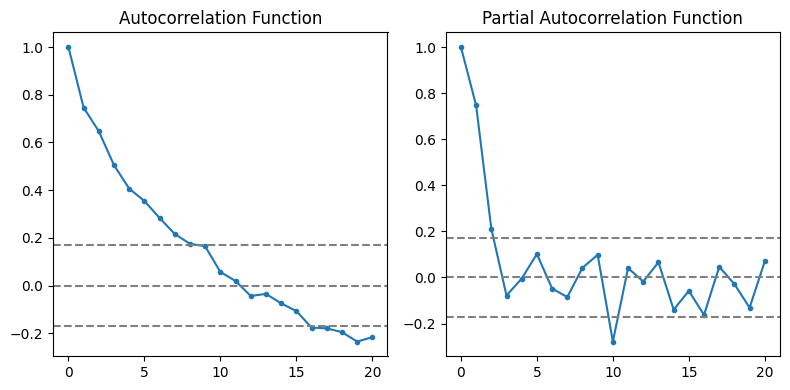

In [ ]:
obtain_order_model(data['seasonal_diff'].dropna())

Separamos nuestros datos en train y test. En este caso los datos de test serán los que corresponden al año 1960.

In [ ]:
data_train = data[:'1959-12-01']
data_test = data['1960-01-01':]

Usamos rápidamente el comando sobre ambos conjuntos de datos para comprobar los tamaños.

In [ ]:
data_train.shape, data_test.shape

((132, 2), (12, 2))

Empezamos inicializando el modelo con orden p=2 y además, observa que vamos a usar los datos estacionarios sin los NAs. Usamos el comando **fit** para entrenar el modelo.

The (p,d,q) order of the model for the autoregressive, differences, and moving average components

In [ ]:
model_ar = ARIMA(data_train['seasonal_diff'].dropna(), order=(2, 0, 0))
model_ar_fitted = model_ar.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Para analizar los resultados podemos usar el comando **summary**:

- Los p-valores son cercanos a 0 por lo que los coeficientes son significativos
- El valor de AIC es igual a 906 y lo usaremos más adelante para comparar los modelos entre sí.

In [ ]:
print(model_ar_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:          seasonal_diff   No. Observations:                  120
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -449.023
Date:                Tue, 20 Jun 2023   AIC                            906.046
Time:                        21:38:25   BIC                            917.196
Sample:                    01-01-1950   HQIC                           910.574
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.6085      5.479      5.586      0.000      19.869      41.348
ar.L1          0.6817      0.097      6.997      0.000       0.491       0.873
ar.L2          0.1641      0.094      1.740      0.0

Finalmente, extraemos los residuos de los datos accediendo a la componente **resid** que guardamos en un nuevo dataframe y que preparamos para después.

In [ ]:
residuals = pd.DataFrame(model_ar_fitted.resid)
residuals = residuals.reset_index()
residuals = residuals.drop(['Month'], axis=1)
residuals.columns = ['residuals']

Vamos a visualizarlos para ver si se parecen a una señal de ruido con una distribución gaussiana. Observa que no existen patrones en los datos y que se encuentran centrados en cero.

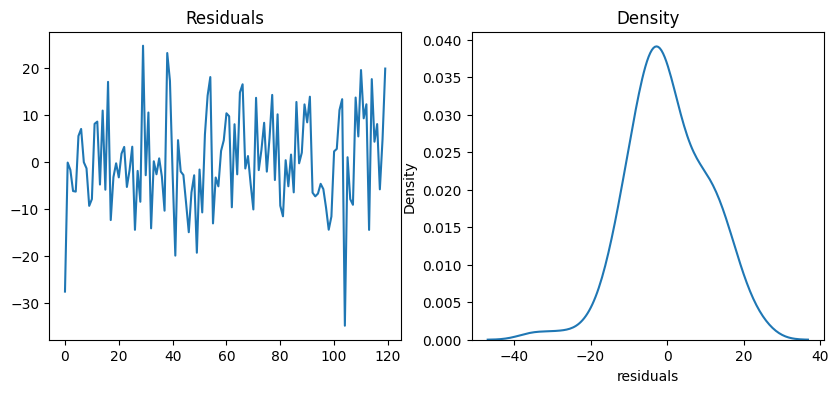

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(residuals)
plt.title('Residuals')
plt.subplot(122)
sns.kdeplot(data=residuals, x="residuals")
plt.title('Density')
plt.show()

Vamos a guardar estas últimas piezas de código en una función que usaremos para analizar más rápidamente el resto de modelos que vamos a crear.

In [ ]:
def model_summary_results(model_fitted):
  # Model summary
  print(model_fitted.summary())

  # Model residuals
  residuals = pd.DataFrame(model_fitted.resid)
  residuals = residuals.reset_index()
  residuals = residuals.drop(['Month'], axis=1)
  residuals.columns = ['residuals']

  # Plot
  plt.figure(figsize=(10,4))
  plt.subplot(121)
  plt.plot(residuals)
  plt.title('Residuals')
  plt.subplot(122)
  sns.kdeplot(data=residuals, x="residuals")
  plt.title('Density')
  plt.show()

Ahora que tenemos nuestro primer modelo, llega el momento de realizar una predicción con él. Para ello usaremos el comando forecast y le vamos a pedir que haga la estimación para los siguientes 12 periodos y que use un umbral de confianza del 5%.

In [ ]:
forecast = model_ar_fitted.forecast(12, alpha=0.05)

Finalmente, visualizamos el resultado de forma gráfica para comparar la estimación y el valor real. Desgraciadamente parece que nuestro modelo no ha sido capaz de capturar el comportamiento de los datos.

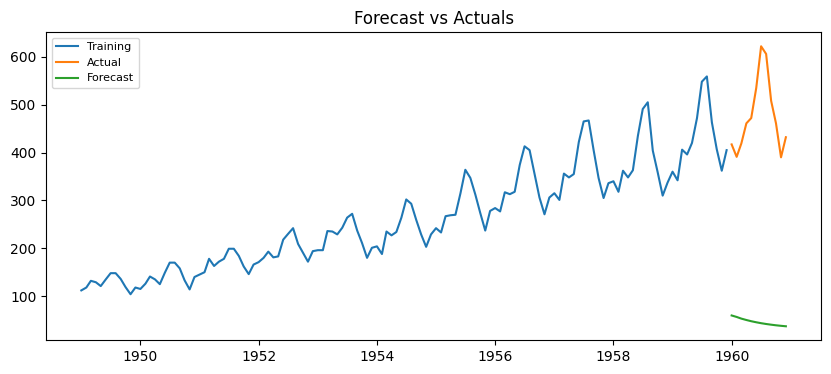

In [ ]:
fc_series = pd.Series(forecast, index=data_test.index)

plt.figure(figsize=(10, 4), dpi=100)
plt.plot(data_train.value, label='Training')
plt.plot(data_test.value, label='Actual')
plt.plot(fc_series, label='Forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Siguiendo la idea de “paquetizar” esas piezas de código que nos pueden resultar útiles vamos a crear una función que nos permita llevar a cabo la predicción de N periodos sobre un modelo concreto y que genere el gráfico que compara la estimación y los valores reales.

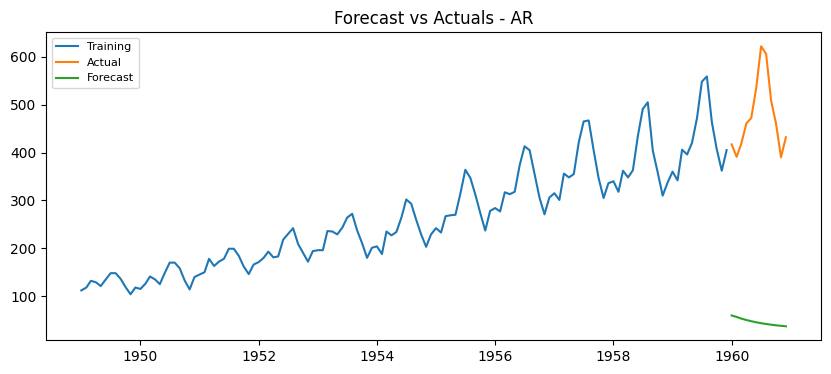

In [ ]:
def forecasting(model_fitted, n_preds, data_test, title):
  # Predict
  forecast = model_fitted.forecast(n_preds, alpha=0.05)

  # Convert predictions to series
  fc_series = pd.Series(forecast, index=data_test.index)

  # Plot
  plt.figure(figsize=(10, 4), dpi=100)
  plt.plot(data_train.value, label='Training')
  plt.plot(data_test.value, label='Actual')
  plt.plot(fc_series, label='Forecast')
  plt.title(title)
  plt.legend(loc='upper left', fontsize=8)
  plt.show()

forecasting(model_ar_fitted, 12, data_test, 'Forecast vs Actuals - AR')

### Modelos MA

Estos modelos se basan en estimar el valor en **t** usando los **q** primeros **errores**. Estos modelos se los podemos atribuir a Herman Wold, de su trabajo de 1938 “A Study in the Analysis of Stationary Time Series”.

En este caso, el concepto de media  móvil se refiere a los términos de error.

Una vez más, el número de errores a considerar vendrá determinado por el orden q del modelo.

¿Cómo obtenemos ese valor de q? Con nuestros gráficos de autocorrelación y de autocorrelación parcial. En este caso es el gráfico de la PACF el que sigue un patrón que se desvanece con deltas de signo invertido y el valor de q será el orden de la última delta significativa en el ACF.

Ahora, por consistencia vamos a generar un modelo MA de orden 2.

Observa que antes las variables que hemos generado usaban “_ar” y ahora vamos a identificar las nuevas variables que generemos con “_ma”. Es una buena práctica usar variables distintas para no sobreescribir resultados intermedios y poder recuperar la información en cualquier momento.

Recuerda que realizamos 3 pasos:

- Inicializar el modelo con los parámetros correspondientes
- Entrenar el modelo
- Analizar los resultados

Inicializamos el modelo con el conjunto de valores (0, 0, 2) y usaremos los datos de la serie estacionaria sin NAs para a continuación entrenar el modelo.

The (p,d,q) order of the model for the autoregressive, differences, and moving average components.

In [ ]:
model_ma = ARIMA(data_train['seasonal_diff'].dropna(), order=(0, 0, 2))
model_ma_fitted = model_ma.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:          seasonal_diff   No. Observations:                  120
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -460.265
Date:                Tue, 20 Jun 2023   AIC                            928.530
Time:                        22:07:16   BIC                            939.680
Sample:                    01-01-1950   HQIC                           933.058
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.2714      2.178     13.899      0.000      26.003      34.540
ma.L1          0.6030      0.082      7.364      0.000       0.443       0.764
ma.L2          0.5678      0.083      6.874      0.0

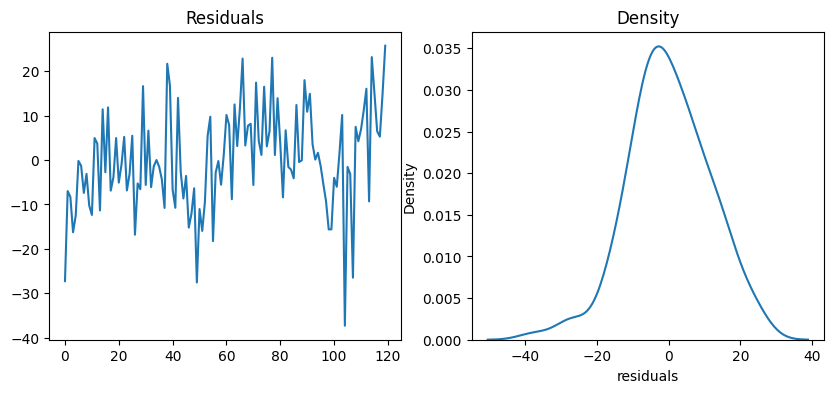

In [ ]:
model_summary_results(model_ma_fitted)

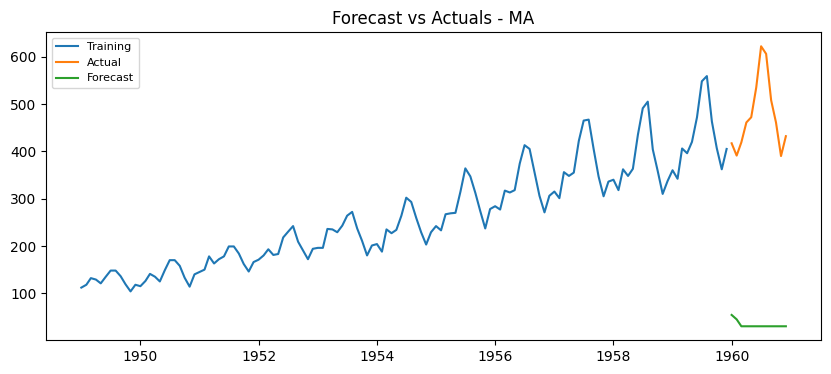

In [ ]:
forecasting(model_ma_fitted, 12, data_test, 'Forecast vs Actuals - MA')

### Modelos ARIMA

Por un lado hemos explicado los modelos AR y los modelos MA. Además, hemos visto de forma práctica como tienen limitaciones a la hora de capturar los patrones de los datos.

Es por ello, que surgen los modelos ARIMA (Autoregressive Integrated moving average model) o modelos de Box-Jenkins. Estos modelos están basados en 3 elementos:

- Una serie de términos autorregresivos
- Una serie de términos de media móvil
- Una operaciones de diferenciación para hacer que la serie temporal sea estacionaria desde el punto de vista de la tendencia. Es decir, los parámetros estadísticos de la tendencias permanecen constantes a lo largo de la serie temporal

Algunas consideraciones sobre la notación a tener en cuenta:

- Un modelo AR(1) es igual a un modelo ARIMA(1,0,0)
- Un modelo MA(1) es igual a un modelo ARIMA(0,0,1)
- Un modelo ARMA(1,1) es igual a un modelo ARIMA(1,0,1)

En el ejemplo anterior hemos generado un modelo AR y un modelo MA. Ahora vamos a probar a crear un modelo que combine ambas componentes: ARIMA(1, 0, 1).

In [ ]:
model_arma = ARIMA(data_train['seasonal_diff'].dropna(), order=(1, 0, 1))
model_arma_fitted = model_arma.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:          seasonal_diff   No. Observations:                  120
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -449.437
Date:                Tue, 20 Jun 2023   AIC                            906.874
Time:                        22:12:45   BIC                            918.024
Sample:                    01-01-1950   HQIC                           911.402
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.5882      5.441      5.622      0.000      19.924      41.252
ar.L1          0.8652      0.061     14.082      0.000       0.745       0.986
ma.L1         -0.1499      0.112     -1.344      0.1

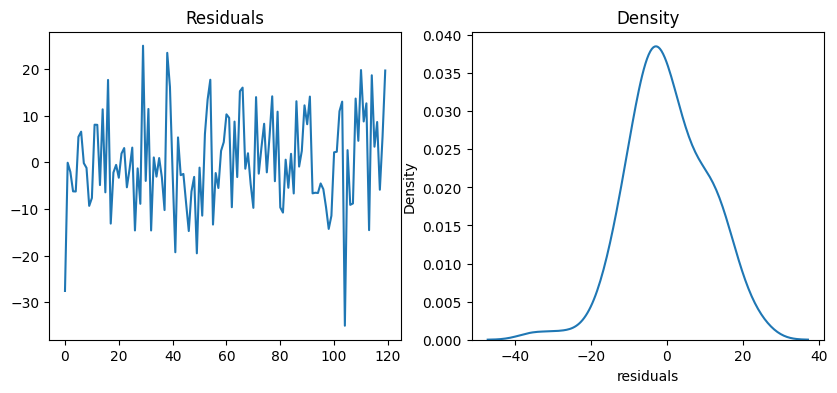

In [ ]:
model_summary_results(model_arma_fitted)

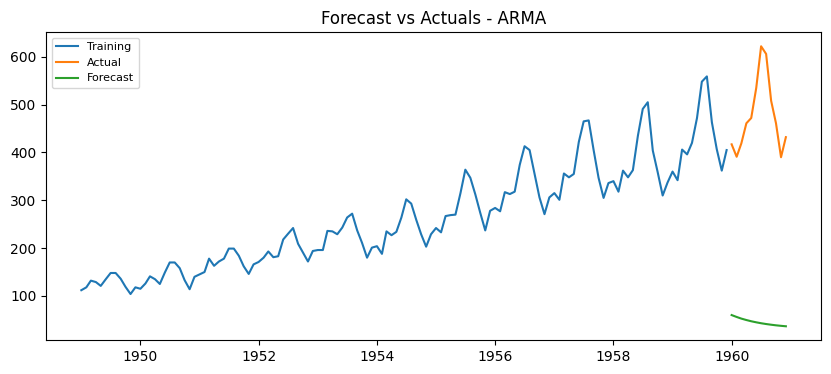

In [ ]:
forecasting(model_arma_fitted, 12, data_test, 'Forecast vs Actuals - ARMA')

Muy bien, hasta aquí hemos hablado de la definición de los valores p y q pero no hemos mencionado nada sobre la forma de obtener el valor del orden de la diferenciación, d, que tenemos que aplicar.

Desgraciadamente, no existe una “receta” o regla, sino que es una conclusión fruto de la experimentación:

- Si nuestro gráfico de autocorrelación muestra un elevado número de deltas con valor mayor del umbral de confianza, eso indica que necesitamos incrementar el valor de d
- Por el contrario si el valor de las deltas del gráfico de autocorrelación se convierte rápidamente en un valor muy negativo, eso nos indica que hemos aplicado un valor de d muy grande y conviene disminuirlo.

Lo más importante a la hora de implementar estos modelos es recordar que se va a aplicar una diferenciación, por ello, usaremos los datos originales para el modelo ARIMA.

In [ ]:
model_arima = ARIMA(data_train['value'].dropna(), order=(1, 1, 1))
model_arima_fitted = model_arima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  132
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -625.518
Date:                Tue, 20 Jun 2023   AIC                           1257.035
Time:                        22:17:29   BIC                           1265.661
Sample:                    01-01-1949   HQIC                          1260.540
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5436      0.100     -5.443      0.000      -0.739      -0.348
ma.L1          0.9272      0.051     18.336      0.000       0.828       1.026
sigma2       816.5398     95.147      8.582      0.0

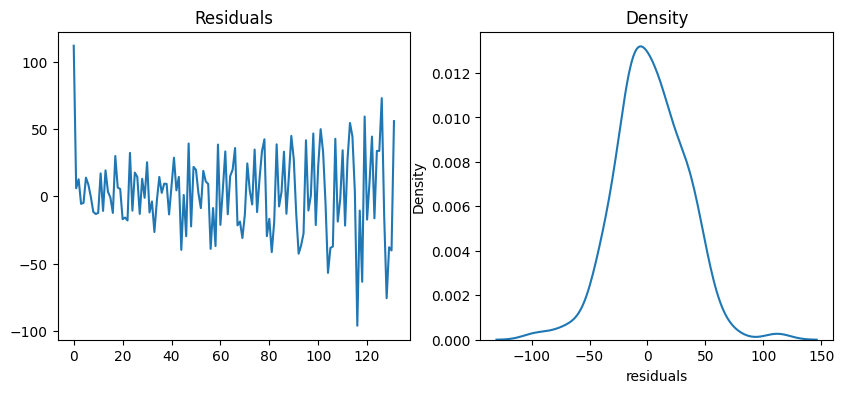

In [ ]:
model_summary_results(model_arima_fitted)

Observa que hemos obtenido una mejora en el AIC, esto normalmente suele indicar que vamos por buen camino y hay que buscar mejoras modificado los coeficientes en este sentido. Por tanto, ahora tendríamos 3 candidatos a probar:

- ARIMA(2, 1, 1)
- ARIMA(1, 2, 1)
- ARIMA(1, 1, 2)

### Probando auto_arima

Por último, para cerrar este apartado relacionado con los modelos ARIMA, es necesario explicar que todo lo que hemos explicado es un proceso muy manual que requiere de un **esfuerzo** por el profesional. Si esta persona solo tiene que trabajar sobre una serie temporal no parece descabellado pero normalmente no se trabaja sobre una única serie temporal por lo que realizar este esfuerzo sobre **decenas o cientos** de series hace que sea imposible.

No somos los primeros que nos enfrentamos a esta situación y por ello surge **autoarima**.

Una librería que se encarga de probar de manera **automática** múltiples combinaciones a partir de una configuración y selecciona el mejor modelo posible en base al AIC.

Para ello vamos a instalar la librería ya que no es de las que viene instalada en Colab por defecto con el comando pip install:

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.6 MB/s eta 0:00:00


In [ ]:
import pmdarima as pm

Para usarlo tenemos que configurar varios parámetros cómo puedes ver a continuación:

- **start_p** y **start_q** definen los valores **iniciales** de los órdenes p y q
- **max_p** y **max_q** definen el valor **máximo** que pueden tomar. Ten en cuenta que valores muy elevados pueden producir problemas de **convergencia**, es decir, que el modelo tienda a infinito
- con **d = None** dejamos que estime su valor

Vamos a ver cómo ejecuta las distintas pruebas para mostrar el mejor modelo al final: ARIMA(3, 0, 2)

In [ ]:
model_autoarima_fitted = pm.auto_arima(data_train.value,
	start_p=1, start_q=1, # initial values of p and q
  test='adf',           # use adftest to find optimal 'd'
  max_p=3, max_q=3,     # maximum p and q
  m=1,                  # frequency of series, 1 means no seasonal data
  d=None,               # let model determine 'd'
  seasonal=False,       # No Seasonality
  start_P=0,
  D=0,
  trace=True,
  error_action='ignore',
  suppress_warnings=True,
  stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1278.850, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1867.156, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1272.828, Time=0.45 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1282.305, Time=0.46 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1273.512, Time=0.95 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1273.413, Time=0.62 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1277.627, Time=0.35 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.77 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1270.547, Time=0.49 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1275.623, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1278.559, Time=0.39 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1270.490, T

In [ ]:
print(model_autoarima_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -627.048
Date:                Tue, 20 Jun 2023   AIC                           1268.097
Time:                        22:48:08   BIC                           1288.276
Sample:                    01-01-1949   HQIC                          1276.297
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6196      2.140      0.290      0.772      -3.574       4.813
ar.L1          1.2375      0.144      8.619      0.000       0.956       1.519
ar.L2          0.0598      0.187      0.319      0.7

### Extensión de los modelos ARIMA

Existen algunas variaciones sobre los modelos ARIMA que nos permiten construir modelos más complejos:

**SARIMA**

Son modelos que incluyen una componente **estacional** a partir de la diferenciación estacional y se identifican de la siguiente manera

SARIMA(p, d, q) x (P, D, Q)

**SARIMAX**

Modelo estacional ARIMA que tiene en cuenta variables **exógenas** para ayudar al modelo a capturar los patrones de comportamiento. Son muy útiles cuando se trabaja con series multivariantes o si tenemos una fuente de información externa.

Ahora, es necesario que demos un paso atrás para poner en acción los modelos SARIMA que incluyan las componentes estacionales y para ello usaremos la función SARIMAX y a la que le vamos a proporcionar 2 conjuntos de valores: **order** y **seasonal_order**.

Observa que esta última se define con (P, D, Q) y usaremos la misma filosofía para definirlos: los gráficos de ACF y de PACF pero usando las deltas que se encuentran en los **múltiplos** de la estacionalidad. En nuestro caso, la serie es mensual y su periodicidad es N=12, por lo que tendremos que usar las deltas en 12, 24, 36, 48,...

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(data_train['value'].dropna(),
  order=(1, 1, 1),
  seasonal_order=(1, 1, 1, 12))
model_sarima_fitted = model_sarima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
print(model_sarima_fitted.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  132
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -445.700
Date:                            Tue, 20 Jun 2023   AIC                            901.399
Time:                                    22:55:11   BIC                            915.295
Sample:                                01-01-1949   HQIC                           907.042
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4952      0.313     -1.580      0.114      -1.109       0.119
ma.L1          0.2559      0.336   

La funcionalidad de auto_arima nos permite generar estos modelos, observa a continuación la forma de obtenerlos:

- seasonal ahora es igual a True
- D=1

In [ ]:
model_sarima_pmdarima_fitted = pm.auto_arima(data_train.value,
	start_p=1, start_q=1,
  test='adf',
  max_p=3, max_q=3,
  m=12,              # month wise series
  d=None,
  seasonal=True,     # For seasonal arima
  start_P=0,
  D=1,               # For seasonal arima
  trace=True,
  error_action='ignore',
  suppress_warnings=True,
  stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=902.221, Time=0.93 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=905.065, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=900.823, Time=0.42 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=901.721, Time=0.45 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=899.902, Time=0.23 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=901.052, Time=0.88 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.63 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=901.337, Time=0.21 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=900.971, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=900.685, Time=0.12 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=902.967, Time=0.46 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=901.457, Time=0.16 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 7.785 seconds


De este apartado nos faltaría por poner en práctica el modelo con variables exógenas: SARIMAX. Para generarlo en nuestro caso al tener una serie temporal univariante vamos a generar una variable nueva que haga referencia a la componente estacional que es muy fuerte en nuestros datos.

Para ello, vamos a coger los últimos 3 años y vamos a usar la descomposición multiplicativa.

In [ ]:
data_components = seasonal_decompose(data['value'][-36:], # last 3 years
	model='multiplicative',
	extrapolate_trend='freq')

Con el parámetro **seasonal** y los últimos 12 valores vamos a generar un dataframe al que añadiremos el identificador del mes extrayéndolo del índice para poder mergear después ambos conjuntos de datos.

In [ ]:
seasonal_index = data_components.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month
seasonal_index

seasonal  month
Month                      
1960-01-01  0.920630      1
1960-02-01  0.856424      2
1960-03-01  0.959662      3
1960-04-01  0.958901      4
1960-05-01  0.990109      5
1960-06-01  1.129714      6
1960-07-01  1.280552      7
1960-08-01  1.279968      8
1960-09-01  1.044181      9
1960-10-01  0.922937     10
1960-11-01  0.791294     11
1960-12-01  0.865628     12

Acuérdate que no tenemos esa variable del mes en los datos originales por lo que vamos a generarla de la misma manera.

In [ ]:
data['month'] = data.index.month

Finalmente, combinamos ambos conjuntos de datos y renombramos las columnas.

In [ ]:
data = pd.merge(data, seasonal_index, how='left', on='month')
data.columns = ['value', 'seasonal_diff', 'month', 'seasonal_index']
data.index = data.index

In [ ]:
data.head(5)

value  seasonal_diff  month  seasonal_index
0    112            NaN      1        0.920630
1    118            NaN      2        0.856424
2    132            NaN      3        0.959662
3    129            NaN      4        0.958901
4    121            NaN      5        0.990109

Al haber modificado los datos tenemos que generar de nuevo los conjuntos de train y test. En este caso vamos a hacerlo usando los últimos 12 valores:

In [ ]:
data_train = data[:-12]
data_test = data[-12:]

Observa en la siguiente pieza de código la forma de incluir esta información: usamos la variable **exogenous**.

In [ ]:
model_sarimax_fitted = pm.auto_arima(data_train[['value']],
	exogenous=data[['seasonal_index']],
  start_p=1, start_q=1,
  test='adf',
  max_p=3, max_q=3,
  m=12,
  start_P=0,
  seasonal=True,
  d=None,
  D=1,
  trace=True,
  error_action='ignore',
  suppress_warnings=True,
  stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=902.221, Time=0.37 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=905.065, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=900.823, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=901.721, Time=0.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=899.902, Time=0.05 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=901.052, Time=0.22 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.17 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=901.337, Time=0.09 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=900.971, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=900.685, Time=0.06 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=902.967, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=901.457, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 2.795 seconds


### Usando prophet

Por último, existen librerías que son capaces de generar modelos más complejos.

En nuestro caso nos vamos a centrar en la librería Prophet. Publicada por Meta en 2017 tanto para Python como R es una librería de código abierto y que podemos consultar en su [repositorio](https://github.com/facebook/prophet) en cualquier momento.

Es una librería muy **completa** ya que ofrece funcionalidades para cubrir todo el proceso que hemos visto a lo largo de este tema. Pero una de sus mayores fortalezas es el **amplio número de parámetros** que permite configurar.

Lo primero que necesitamos hacer es instalarla junto con pystan ya que es una de sus dependencias. Tarda bastante en instalarla así que ten paciencia y aunque veas un mensaje de error espera hasta el final ya que consigue resolver el problema y mostrará por pantalla que dice “Successfully installed fbprophet-0.7.1 pystan-2.19.1.1”

In [ ]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

In [ ]:
data = pd.read_csv('airline_passengers.csv')
data.head(1)

Month  value
0  1949-01    112

In [ ]:
data['Month'] = pd.DatetimeIndex(data['Month'])
data.dtypes

data = data.rename(columns={'Month': 'ds',
  'value': 'y'})

data.head(1)

ds    y
0 1949-01-01  112

Para crear nuestro primer modelo con Prophet vamos a inicializar un modelo muy sencillo:

In [ ]:
my_model_basic = Prophet(interval_width=0.95) # default value is 80%
my_model_basic

Y lo entrenamos sobre los datos.

In [ ]:
my_model_basic.fit(data)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7s6itedn/jsfu1zvw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7s6itedn/ubt1594_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43387', 'data', 'file=/tmp/tmp7s6itedn/jsfu1zvw.json', 'init=/tmp/tmp7s6itedn/ubt1594_.json', 'output', 'file=/tmp/tmp7s6itedn/prophet_modelsfxcr27m/prophet_model-20230620235747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:57:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:57:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


La realización de las predicciones es otra de las particularidades de esta librería: necesitamos crear un nuevo dataframe y para ello usaremos la función **make_future_dataframe** al que tenemos que indicar que generé un número de periodos según nuestro horizonte de predicción y le indicaremos la frecuencia  de los datos, el famoso **MS** que hemos visto al comienzo de la unidad.

In [ ]:
future_dates = my_model_basic.make_future_dataframe(periods=12, freq='MS')

Para la predicción usaremos el comando predict.

In [ ]:
forecast = my_model_basic.predict(future_dates)

Si visualizas uno de los registros vas a ver que se generan muchas columnas. Para facilitar el trabajo puedes seleccionar aquellas variables que te interesan.

In [ ]:
forecast.tail(1)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
155 1961-12-01  521.338087   444.32332  531.970249   520.244314   522.528453   

     additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
155      -32.314118            -32.314118            -32.314118 -32.314118   

     yearly_lower  yearly_upper  multiplicative_terms  \
155    -32.314118    -32.314118                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
155                         0.0                         0.0  489.023969

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend']].tail(1)

ds        yhat  yhat_lower  yhat_upper       trend
155 1961-12-01  489.023969   444.32332  531.970249  521.338087

Para analizar los resultados tenemos varias opciones. En primer lugar, generar un gráfico con la estimación del modelo. Observa que se muestra los valores estimados a lo largo de la evolución y el intervalo de confianza (zona sombreada).

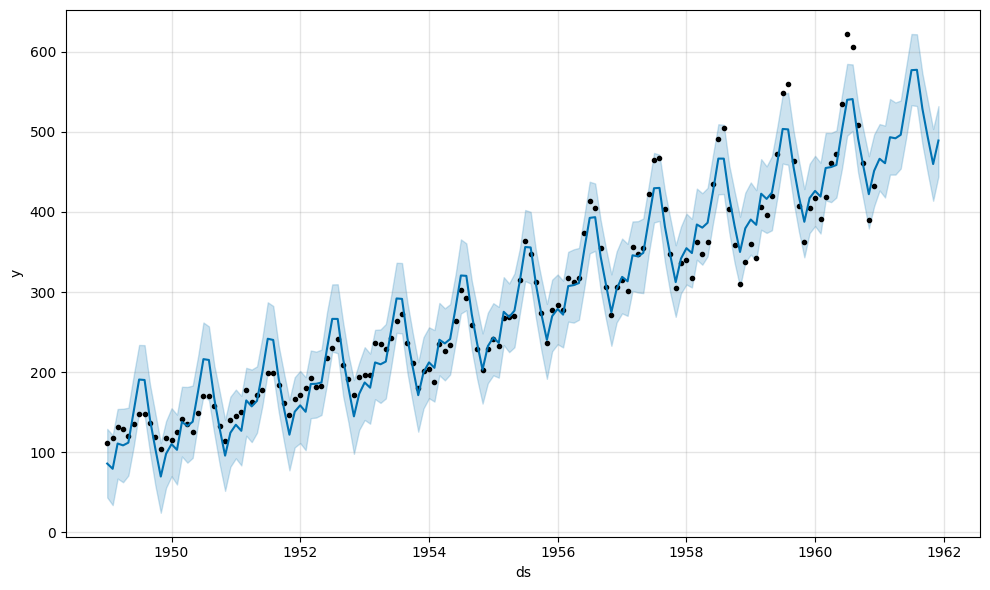

In [ ]:
my_model_basic.plot(forecast, uncertainty=True);

Para poder entender el resultado podemos visualizar las distintas componentes del modelo. En nuestro caso una componente de tendencia que muestra la tendencia creciente a lo largo de los años y una componente anual que muestra la evolución a lo largo de los años naturales.

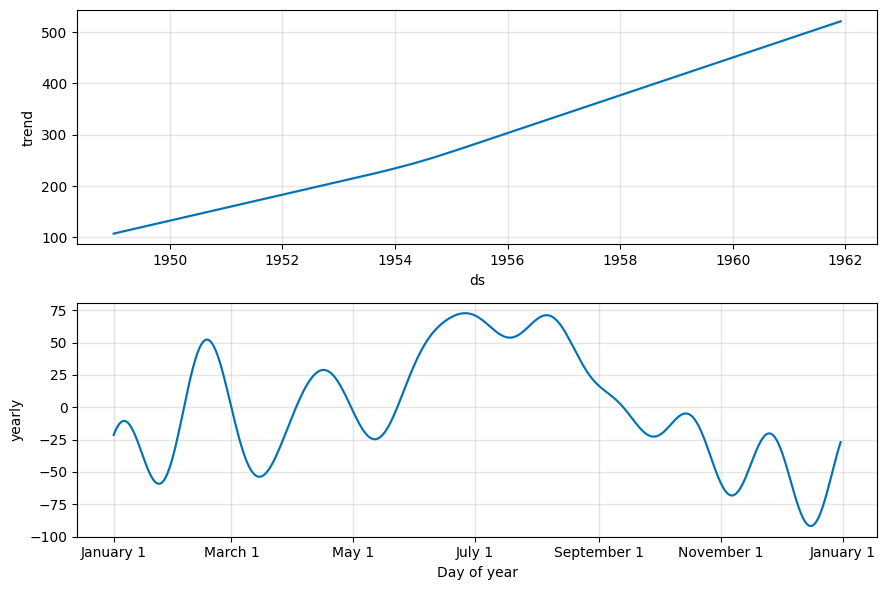

In [ ]:
my_model_basic.plot_components(forecast);

Una de las mayores fortalezas de esta librería es el uso de los **changepoints**. Puntos que se usan para definir cambios bruscos en la tendencia ya que los datos reales normalmente muestran este tipo de comportamiento. Por defecto la librería se encarga de detectarlos de forma automática (se definen 25 puntos potenciales a lo largo del 80% de los datos de entrenamiento sobre los que se aplica una regularización) pero podríamos definir en qué punto queremos considerar esos cambios.

Podemos ver los puntos que se consideran en nuestro modelo de la siguiente forma.

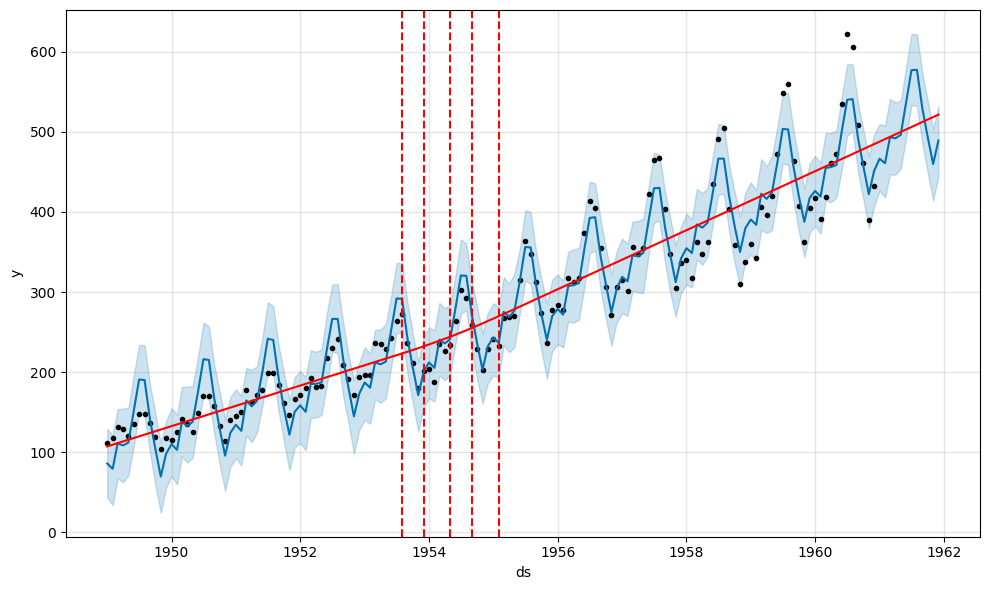

In [ ]:
fig = my_model_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), my_model_basic, forecast)

Otra manera de visualizarlos es viendo los coeficientes distintos de cero:

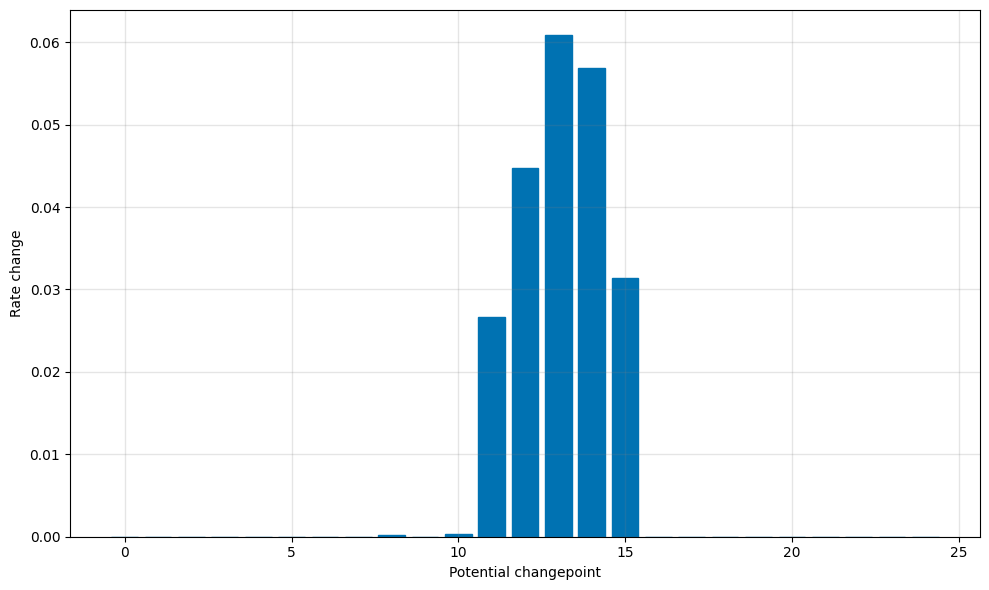

In [ ]:
deltas = my_model_basic.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

La segunda fortaleza que queremos mostrar aquí es la capacidad de generar componentes estacionales personalizadas a partir de series de Fourier a parte de las componente anuales, semanales y diarias que incluye Prophet por defecto.

En nuestro caso, vamos a probar a definir una componente periódica que simula los cambios a lo largo de un mes. Este tipo de componentes puede ser interesante si nuestros datos dependen de este tipo de patrones. Para ello usaremos un periodo de 30.5 días ya que algunos meses tienen 30 y otros tienen 31, y el orden de Fourier igual a 5 (valores mayores permiten mayor variabilidad a lo largo del mes y valores más bajos definirán componentes más rígidas)

In [ ]:
my_model_seasonal = Prophet(interval_width=0.95,
  yearly_seasonality = True,
  weekly_seasonality = False,
  daily_seasonality = False)

my_model_seasonal.add_seasonality(name='monthly',
  period=30.5,
  fourier_order=5)

Entrenamos el modelo sobre los datos y creamos las predicciones.

In [ ]:
my_model_seasonal.fit(data)

forecast_seasonal = my_model_seasonal.predict(future_dates)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7s6itedn/gwfqy2hu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7s6itedn/rtw3_98_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64730', 'data', 'file=/tmp/tmp7s6itedn/gwfqy2hu.json', 'init=/tmp/tmp7s6itedn/rtw3_98_.json', 'output', 'file=/tmp/tmp7s6itedn/prophet_modelf4sfiu7o/prophet_model-20230621011805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:18:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:18:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Finalmente, visualizamos las componentes. Observa el patrón con 3 picos: semana 1, semana 3 (aproximadamente) y final de mes.

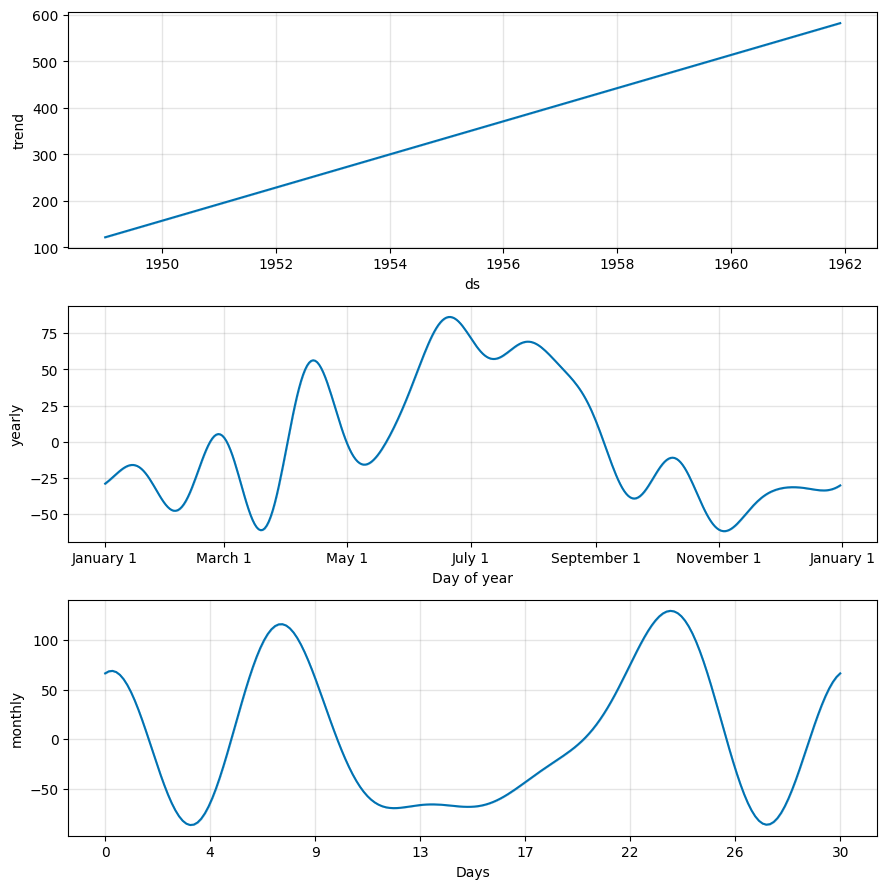

In [ ]:
my_model_seasonal.plot_components(forecast_seasonal);

### Medidas de error

**¿Qué medidas de error podemos usar en series temporales?**

Para responder a esto hay que valorar dos cosas:

- Uno de los aspectos más importantes a tener en cuenta es el orden de magnitud de nuestra variable, por ello, las medidas de error basadas en porcentajes son muy útiles
- El segundo aspecto a valorar, es que podemos tener errores por exceso (el valor predicho es mayor que el valor real) o por defecto (el valor predicho es menor que el valor real). Estos dos tipos de error al tener signo opuesto se compensan. Es decir, si tenemos un error de +10 y un error de -10 el error total será de 0, esto nos puede hacer pensar que nuestro modelo está funcionando muy bien pero nada más lejos de la realidad. Por tanto, es recomendable usar medidas basadas en valor absoluto, para que los signos diferentes no distorsionen nuestros resultados.

Por todo ello, la mejor opción será el MAPE: Mean Absolute Percentage error.

Al final definir la barrera para decir si un modelo es bueno o malo va a depender del posible caso de uso que estemos resolviendo y del impacto de dicho error en el negocio. Pero la regla general es la siguiente:

- Si el MAPE < 10% el modelo es muy bueno
- Si el MAPE se encuentra entre el 10% y el 20% el modelo es bueno
- En el caso de que el MAPE tenga un valor entre 20% y 50% es modelo es normal
- Si el MAPE es mayor del 50% el modelo será malo

In [ ]:
import numpy as np
import pandas as pd

Creamos 2 series de valores: los valores reales de nuestra serie en la variable **values** y los valores predichos por el modelo en la variable **pred_values**. Asignamos los nombres de **y** e **y_hat** respectivamente. Con ellos creamos un dataframe al que añadimos un índice con 5 fechas desde el 1 de enero de 2010.

In [ ]:
values = [11, 13, 12, 15, 19]
pred_values = [10, 14, 9, 11, 13]

df = pd.DataFrame(
  data={'y': values, 'y_hat': pred_values},
  index=pd.date_range(start='2010-01-01', freq='MS', periods=5)
)

In [ ]:
df.head()

y  y_hat
2010-01-01  11     10
2010-02-01  13     14
2010-03-01  12      9
2010-04-01  15     11
2010-05-01  19     13

Siguiendo la filosofía de generar funciones que faciliten la aplicación de las mismas piezas de código en distintas ocasiones vamos a generar una función que se encargue de obtener las medidas de error que vamos a utilizar:

- ME: mean error
- MAE: mean absolute error
- RMSE: root mean square error
- MAPE: mean absolute percentage error

In [ ]:
def forecast_accuracy(predicted, real):
  me = np.mean(predicted - real)                        # ME
  mae = np.mean(np.abs(predicted - real))               # MAE
  mape = np.mean(np.abs(predicted - real)/np.abs(real)) # MAPE
  rmse = np.mean((predicted - real)**2)**.5             # RMSE

  return({'me':me, 'mae': mae, 'mape':mape, 'rmse':rmse})

In [ ]:
forecast_accuracy(df.y_hat, df.y)

{'me': -2.6,
 'mae': 3.0,
 'mape': 0.20005766163660904,
 'rmse': 3.5496478698597698}